In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report, log_loss
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, AlphaDropout, BatchNormalization, Add, concatenate
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from xgboost import XGBClassifier
import xgboost

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({'font.size':15})

In [3]:
pwd

'/home/ubuntu/Galvanize-DSI-Capstone-Project-3'

In [3]:
# Read all datasets
test_feat = pd.read_csv('data/test_features.csv')
train_drug = pd.read_csv('data/train_drug.csv')
train_feat = pd.read_csv('data/train_features.csv')
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv')
train_targets_scored = pd.read_csv('data/train_targets_scored.csv')

# Categorical to numerical
train_feat.cp_time = train_feat.cp_time.map({24: 1, 48: 2, 72: 3}).astype(int)
train_feat = pd.get_dummies(train_feat, columns=['cp_type'], prefix="cp_type", drop_first=True)
train_feat = pd.get_dummies(train_feat, columns=["cp_dose"], prefix="cp_dose", drop_first=True)

test_feat.cp_time = test_feat.cp_time.map({24: 1, 48: 2, 72: 3}).astype(int)
test_feat = pd.get_dummies(test_feat, columns=["cp_type"], prefix="cp_type", drop_first=True)
test_feat = pd.get_dummies(test_feat, columns=["cp_dose"], prefix="cp_dose", drop_first=True)

# Get X, y using train datasets
X = train_feat.drop('sig_id', axis=1).values
y = train_targets_scored.drop('sig_id', axis=1).values

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((17860, 875), (17860, 206), (5954, 875), (5954, 206))

In [4]:
# Need to define the log-loss metric required by the competition, see formula here:
# https://www.kaggle.com/c/lish-moa/overview/evaluation
def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 0.001, 0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [132]:
n_cols

875

In [134]:
# Build a basic MLP model first
def build_model(n_cols):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(n_cols,)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model 

n_cols = X_train.shape[1]
mlp = build_model(n_cols)
mlp.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 64)                56064     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_40 (Batc (None, 128)               512       
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 206)               26574     
Total params: 91,470
Trainable params: 91,214
Non-trainable params: 256
_______________________________________________

In [135]:
earlystp_mlp = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/mlp'
checkpoint_mlp = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_mlp = mlp.fit(
    X_train, y_train, batch_size=32,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[checkpoint_mlp, earlystp_mlp])

score = mlp.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

mlp.save('models/mlp_complete')

Epoch 1/50
559/559 [==============================] - 3s 4ms/step - loss: 0.3741 - logloss: 0.3733 - val_loss: 0.0233 - val_logloss: 0.0206

Epoch 00001: loss improved from inf to 0.16404, saving model to models/mlp
INFO:tensorflow:Assets written to: models/mlp/assets
Epoch 2/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0235 - logloss: 0.0208 - val_loss: 0.0215 - val_logloss: 0.0185

Epoch 00002: loss improved from 0.16404 to 0.02317, saving model to models/mlp
INFO:tensorflow:Assets written to: models/mlp/assets
Epoch 3/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0220 - logloss: 0.0190 - val_loss: 0.0205 - val_logloss: 0.0173

Epoch 00003: loss improved from 0.02317 to 0.02167, saving model to models/mlp
INFO:tensorflow:Assets written to: models/mlp/assets
Epoch 4/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0209 - logloss: 0.0178 - val_loss: 0.0199 - val_logloss: 0.0167

Epoch 00004: loss improved from 0.02167 to 0

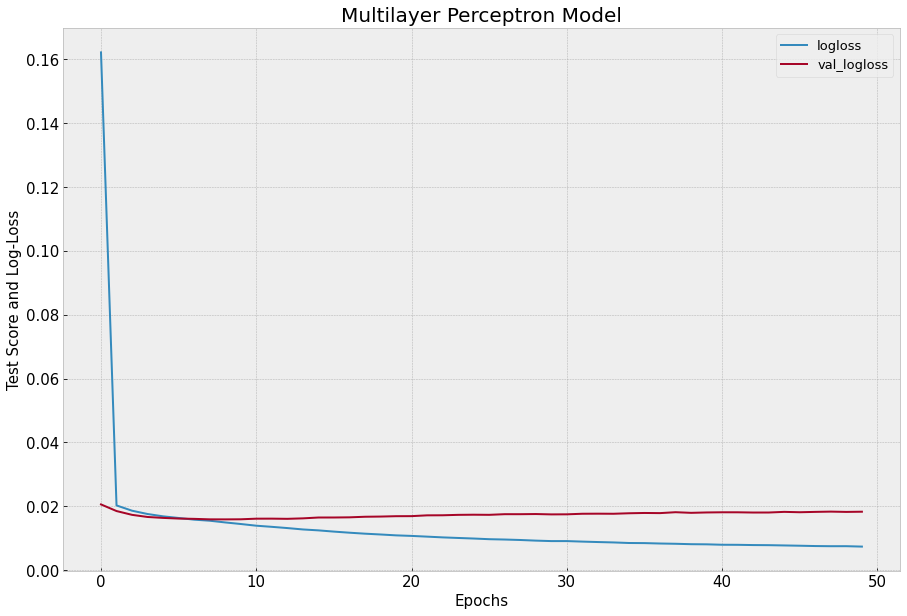

In [136]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_mlp.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('Multilayer Perceptron Model', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/mlp.jpg')

Try out a 1-D convolutional NN:

Reshaping the datasets which is necessary for building a 1-D CNN model

In [137]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    
n_cols = X_train_reshaped.shape[1]

In [138]:
def build_conv1D_model(n_cols):

    model = keras.Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_cols, 1)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
    model.add(keras.layers.Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(keras.layers.Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model

n_cols = X_train_reshaped.shape[1]
conv1d = build_conv1D_model(n_cols)
conv1d.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_168 (Conv1D)          (None, 873, 32)           128       
_________________________________________________________________
conv1d_169 (Conv1D)          (None, 871, 32)           3104      
_________________________________________________________________
conv1d_170 (Conv1D)          (None, 869, 64)           6208      
_________________________________________________________________
max_pooling1d_90 (MaxPooling (None, 434, 64)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 434, 64)           0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 27776)             0         
_________________________________________________________________
dense_75 (Dense)             (None, 32)              

In [140]:
earlystp_conv1d = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/conv1d'
checkpoint_conv1d = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_covn1d = conv1d.fit(
    X_train_reshaped, y_train, batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_conv1d, earlystp_conv1d])

score = conv1d.evaluate(X_val_reshaped, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

conv1d.save('models/conv1d_complete')

Epoch 1/50
559/559 [==============================] - 4s 7ms/step - loss: 0.0190 - logloss: 0.0156 - val_loss: 0.0202 - val_logloss: 0.0166

Epoch 00001: loss improved from inf to 0.01900, saving model to models/conv1d
INFO:tensorflow:Assets written to: models/conv1d/assets
Epoch 2/50
559/559 [==============================] - 4s 7ms/step - loss: 0.0186 - logloss: 0.0152 - val_loss: 0.0206 - val_logloss: 0.0167

Epoch 00002: loss improved from 0.01900 to 0.01864, saving model to models/conv1d
INFO:tensorflow:Assets written to: models/conv1d/assets
Epoch 3/50
559/559 [==============================] - 4s 7ms/step - loss: 0.0183 - logloss: 0.0148 - val_loss: 0.0216 - val_logloss: 0.0171

Epoch 00003: loss improved from 0.01864 to 0.01829, saving model to models/conv1d
INFO:tensorflow:Assets written to: models/conv1d/assets
Epoch 4/50
559/559 [==============================] - 4s 6ms/step - loss: 0.0178 - logloss: 0.0143 - val_loss: 0.0219 - val_logloss: 0.0172

Epoch 00004: loss improved

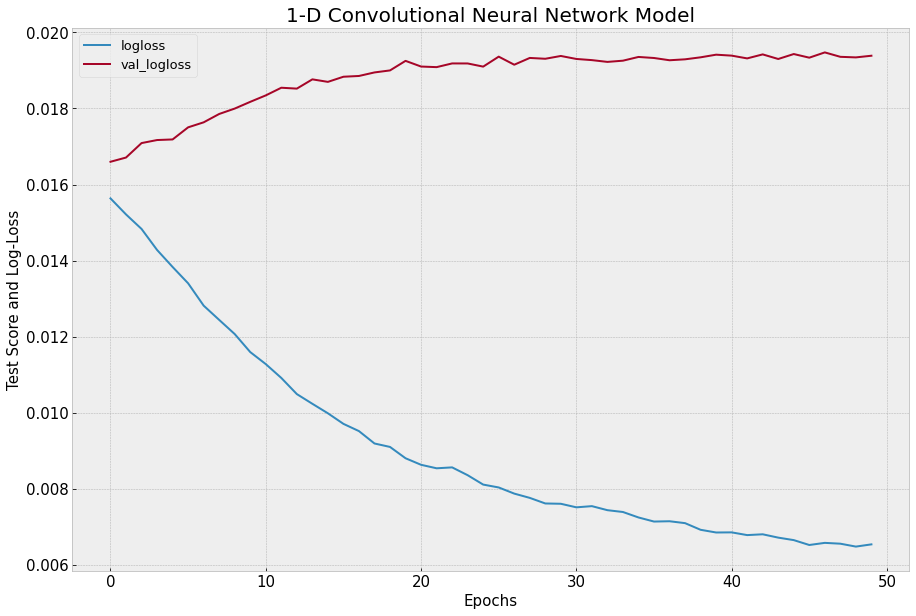

In [142]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_covn1d.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('1-D Convolutional Neural Network Model', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/conv1d.jpg')

1-D CNN did a very bad job compared to mlp. It simply overfitting at the beginning. So will use mlp for a PCA analysis.

In [6]:
# Try to find out optimal number of principal components
log_loss_score =[]

for i in range(10, 500, 20):
    print("Principal Components: ", i)
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    X_pca_train, X_pca_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.25, shuffle=True, random_state=1)

    n_cols = X_pca_train.shape[1]
    
    earlystp_pca_mlp = EarlyStopping(monitor='loss', patience=5)
    filepath = 'models/pca_mlp'
    checkpoint_pca_mlp = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

    model_pca_mlp = build_model(n_cols)
    history_pca_mlp = model_pca_mlp.fit(
        X_pca_train, y_train, batch_size=32,
        validation_data=(X_pca_val, y_val),
        epochs=50,
        callbacks=[checkpoint_pca_mlp, earlystp_pca_mlp])
    
    score = model_pca_mlp.evaluate(X_pca_val, y_val, verbose=0)
    log_loss_score.append([i, score[1]])

Principal Components:  10
Epoch 1/50
559/559 [==============================] - 22s 6ms/step - loss: 0.3775 - logloss: 0.3766 - val_loss: 0.0230 - val_logloss: 0.0203
INFO:tensorflow:Assets written to: models/pca_mlp/assets
Epoch 2/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0233 - logloss: 0.0205 - val_loss: 0.0216 - val_logloss: 0.0186
INFO:tensorflow:Assets written to: models/pca_mlp/assets
Epoch 3/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0224 - logloss: 0.0194 - val_loss: 0.0214 - val_logloss: 0.0183
INFO:tensorflow:Assets written to: models/pca_mlp/assets
Epoch 4/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0218 - logloss: 0.0187 - val_loss: 0.0212 - val_logloss: 0.0180
INFO:tensorflow:Assets written to: models/pca_mlp/assets
Epoch 5/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0217 - logloss: 0.0186 - val_loss: 0.0210 - val_logloss: 0.0179
INFO:tensorflow:Assets written to: models/pca

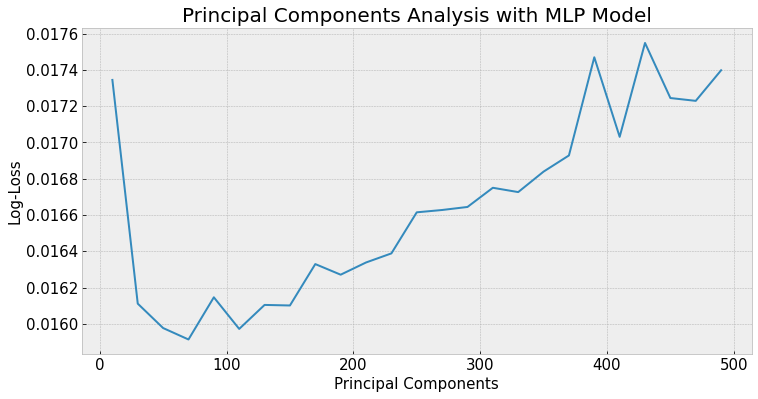

In [8]:
# plot PCA
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.array(log_loss_score)[:,0], np.array(log_loss_score)[:,1])
ax.set_xlabel('Principal Components', fontsize=15)
ax.set_ylabel('Log-Loss', fontsize=15)
ax.set_title('Principal Components Analysis with MLP Model', fontsize=20)
plt.savefig('images/pca.jpg')

In [105]:
# Build a AlexNet model
# https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/

# Get principal components
n_components = 122
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
X_pca_train, X_pca_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.25, shuffle=True, random_state=1)

X_pca_train_reshaped = X_pca_train.reshape(X_pca_train.shape[0], X_pca_train.shape[1], 1)
X_pca_val_reshaped = X_pca_val.reshape(X_pca_val.shape[0], X_pca_val.shape[1], 1)
    
n_cols = X_pca_train_reshaped.shape[1]


In [106]:
X_pca_train.shape, X_pca_train_reshaped.shape, X_pca_val.shape, X_pca_val_reshaped.shape, y_train.shape, y_val.shape, n_cols

((17860, 122),
 (17860, 122, 1),
 (5954, 122),
 (5954, 122, 1),
 (17860, 206),
 (5954, 206),
 122)

In [108]:
def AlexNet_model(n_cols):
    #Instantiation
    AlexNet = Sequential()

    #1st Convolutional Layer
    AlexNet.add(Conv1D(filters=96, input_shape=(n_cols, 1), kernel_size=5, strides=3))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

    #2nd Convolutional Layer
    AlexNet.add(Conv1D(filters=256, kernel_size=5, strides=1))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

    #3rd Convolutional Layer
    AlexNet.add(Conv1D(filters=384, kernel_size=3, strides=1))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #4th Convolutional Layer
    AlexNet.add(Conv1D(filters=384, kernel_size=3, strides=1))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #5th Convolutional Layer
    AlexNet.add(Conv1D(filters=256, kernel_size=3, strides=1))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    AlexNet.add(Dropout(0.4))

    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #3rd Fully Connected Layer
    AlexNet.add(Dense(1000))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #Output Layer
    AlexNet.add(Dense(206))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('sigmoid'))

    # Compiling the model
    AlexNet.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return AlexNet

#Model Summary
AlexNet = AlexNet_model(n_cols)
AlexNet.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_153 (Conv1D)          (None, 40, 96)            576       
_________________________________________________________________
batch_normalization_29 (Batc (None, 40, 96)            384       
_________________________________________________________________
activation_190 (Activation)  (None, 40, 96)            0         
_________________________________________________________________
max_pooling1d_84 (MaxPooling (None, 20, 96)            0         
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 16, 256)           123136    
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 256)           1024      
_________________________________________________________________
activation_191 (Activation)  (None, 16, 256)         

In [109]:
# Fit the AlexNet model
earlystp_alexnet = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/alexnet'
checkpoint_alexnet = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

history_alexnet = AlexNet.fit(
    X_pca_train_reshaped, y_train, batch_size=32,
    validation_data=(X_pca_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_alexnet, earlystp_alexnet])

score = AlexNet.evaluate(X_pca_val_reshaped, y_val, verbose=0)

AlexNet.save('models/alexnet_complete')


Epoch 1/50
559/559 [==============================] - 10s 14ms/step - loss: 0.6931 - logloss: 0.6931 - val_loss: 0.5156 - val_logloss: 0.5013
INFO:tensorflow:Assets written to: models/alexnet/assets
Epoch 2/50
559/559 [==============================] - 7s 13ms/step - loss: 0.4422 - logloss: 0.4419 - val_loss: 0.3296 - val_logloss: 0.3291
INFO:tensorflow:Assets written to: models/alexnet/assets
Epoch 3/50
559/559 [==============================] - 7s 13ms/step - loss: 0.2993 - logloss: 0.2987 - val_loss: 0.2318 - val_logloss: 0.2311
INFO:tensorflow:Assets written to: models/alexnet/assets
Epoch 4/50
559/559 [==============================] - 8s 13ms/step - loss: 0.2150 - logloss: 0.2143 - val_loss: 0.1708 - val_logloss: 0.1699
INFO:tensorflow:Assets written to: models/alexnet/assets
Epoch 5/50
559/559 [==============================] - 8s 14ms/step - loss: 0.1598 - logloss: 0.1589 - val_loss: 0.1295 - val_logloss: 0.1285
INFO:tensorflow:Assets written to: models/alexnet/assets
Epoch 6/5

In [110]:
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

Test loss: 0.023791542276740074
Test log-loss:  0.019892331212759018


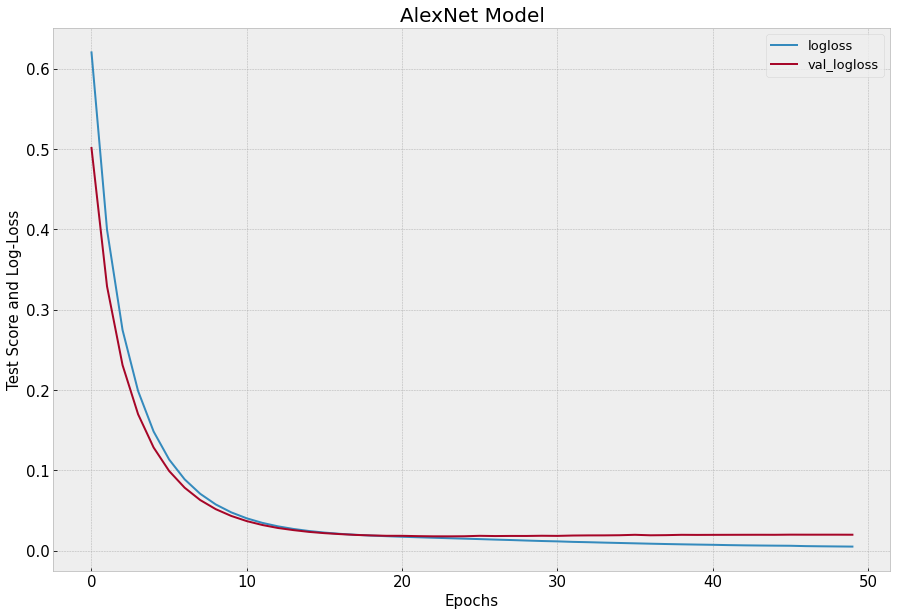

In [111]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_alexnet.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('AlexNet Model', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/alexnet.jpg')

In [101]:
# Build a AlexNet model
# it seems n_components has to be bigger than or equal to 122 for the model to be built successfully!!!

# Get principal components
n_components = 122
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
X_pca_train, X_pca_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.25, shuffle=True, random_state=1)

X_pca_train_reshaped = X_pca_train.reshape(X_pca_train.shape[0], X_pca_train.shape[1], 1)
X_pca_val_reshaped = X_pca_val.reshape(X_pca_val.shape[0], X_pca_val.shape[1], 1)
    
n_cols = X_pca_train_reshaped.shape[1]


In [102]:
X_pca_train.shape, X_pca_train_reshaped.shape, X_pca_val.shape, X_pca_val_reshaped.shape, y_train.shape, y_val.shape, n_cols

((17860, 122),
 (17860, 122, 1),
 (5954, 122),
 (5954, 122, 1),
 (17860, 206),
 (5954, 206),
 122)

In [112]:
def AlexNet_selu_model(n_cols):
    #Instantiation
    AlexNet = Sequential()

    #1st Convolutional Layer
    AlexNet.add(Conv1D(filters=96, kernel_initializer=LecunNormal(), input_shape=(n_cols, 1), kernel_size=5, strides=3))
    AlexNet.add(Activation('selu'))
    AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

    #2nd Convolutional Layer
    AlexNet.add(Conv1D(filters=256, kernel_initializer=LecunNormal(), kernel_size=5, strides=1))
    AlexNet.add(Activation('selu'))
    AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

    #3rd Convolutional Layer
    AlexNet.add(Conv1D(filters=384, kernel_initializer=LecunNormal(), kernel_size=3, strides=1))
    AlexNet.add(Activation('selu'))

    #4th Convolutional Layer
    AlexNet.add(Conv1D(filters=384, kernel_initializer=LecunNormal(), kernel_size=3, strides=1))
    AlexNet.add(Activation('selu'))

    #5th Convolutional Layer
    AlexNet.add(Conv1D(filters=256, kernel_initializer=LecunNormal(), kernel_size=3, strides=1))
    AlexNet.add(Activation('selu'))
    AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096, kernel_initializer=LecunNormal(), input_shape=(32,32,3,)))
    AlexNet.add(Activation('selu'))
    # Add Dropout to prevent overfitting
    AlexNet.add(AlphaDropout(0.6))

    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096, kernel_initializer=LecunNormal()))
    AlexNet.add(Activation('selu'))
    #Add Dropout
    AlexNet.add(AlphaDropout(0.6))

    #3rd Fully Connected Layer
    AlexNet.add(Dense(1000, kernel_initializer=LecunNormal()))
    AlexNet.add(Activation('selu'))
    #Add Dropout
    AlexNet.add(AlphaDropout(0.6))

    #Output Layer
    AlexNet.add(Dense(206))
    AlexNet.add(Activation('sigmoid'))

    # Compiling the model
    AlexNet.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)
    
    return AlexNet

#Model Summary
AlexNet_selu = AlexNet_selu_model(n_cols)
AlexNet_selu.summary()




Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_158 (Conv1D)          (None, 40, 96)            576       
_________________________________________________________________
activation_199 (Activation)  (None, 40, 96)            0         
_________________________________________________________________
max_pooling1d_87 (MaxPooling (None, 20, 96)            0         
_________________________________________________________________
conv1d_159 (Conv1D)          (None, 16, 256)           123136    
_________________________________________________________________
activation_200 (Activation)  (None, 16, 256)           0         
_________________________________________________________________
max_pooling1d_88 (MaxPooling (None, 8, 256)            0         
_________________________________________________________________
conv1d_160 (Conv1D)          (None, 6, 384)          

In [115]:
# Fit the AlexNet_selu model
#earlystp_alexnet_selu = EarlyStopping(monitor='loss', patience=8)
filepath = 'models/alexnet_selu'
checkpoint_alexnet_selu = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

history_alexnet_selu = AlexNet_selu.fit(
    X_pca_train_reshaped, y_train, batch_size=32,
    validation_data=(X_pca_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_alexnet_selu]) #, earlystp_alexnet_selu])

score = AlexNet_selu.evaluate(X_pca_val_reshaped, y_val, verbose=0)

AlexNet_selu.save('models/alexnet_selu_complete')

Epoch 1/50
559/559 [==============================] - 6s 10ms/step - loss: 0.0589 - logloss: 0.0239 - val_loss: 0.0493 - val_logloss: 0.0243
INFO:tensorflow:Assets written to: models/alexnet_selu/assets
Epoch 2/50
559/559 [==============================] - 6s 10ms/step - loss: 0.0276 - logloss: 0.0220 - val_loss: 0.0489 - val_logloss: 0.0243
INFO:tensorflow:Assets written to: models/alexnet_selu/assets
Epoch 3/50
559/559 [==============================] - 6s 10ms/step - loss: 0.0308 - logloss: 0.0219 - val_loss: 0.0498 - val_logloss: 0.0243
Epoch 4/50
559/559 [==============================] - 6s 10ms/step - loss: 0.0770 - logloss: 0.0228 - val_loss: 0.0514 - val_logloss: 0.0243
Epoch 5/50
559/559 [==============================] - 6s 10ms/step - loss: 0.0776 - logloss: 0.0226 - val_loss: 0.0499 - val_logloss: 0.0243
Epoch 6/50
559/559 [==============================] - 6s 10ms/step - loss: 0.0324 - logloss: 0.0220 - val_loss: 0.0490 - val_logloss: 0.0243
Epoch 7/50
559/559 [==========

Test loss: 0.053377531468868256
Test log-loss:  0.024319885298609734


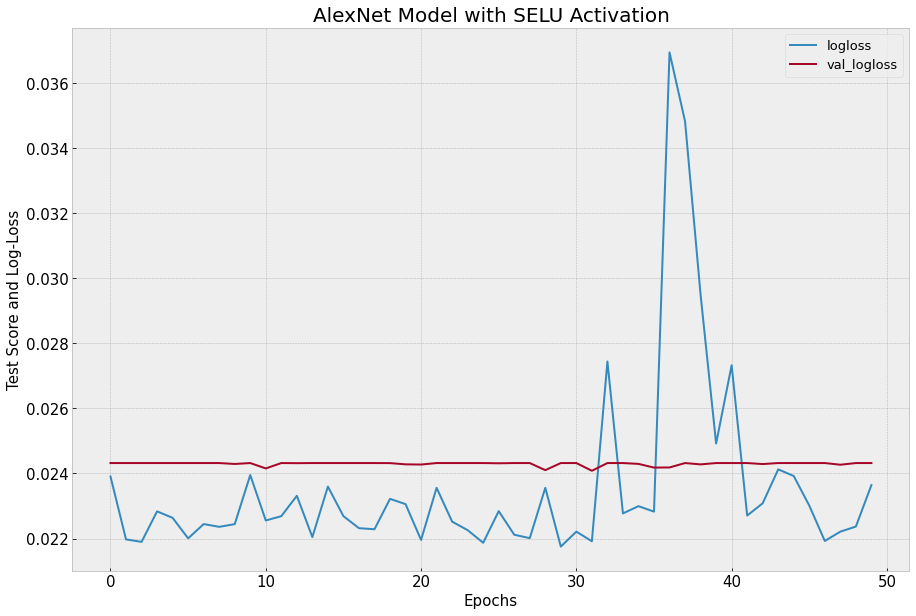

In [121]:
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_alexnet_selu.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('AlexNet Model with SELU Activation', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/alexnet_selu.jpg')

Very bad.

Try a LeNet-5 model

In [124]:
# https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086

def lenet5_model(n_cols):
    model = Sequential()

    model.add(Conv1D(filters=96, input_shape=(n_cols, 1), kernel_size=5, strides=3, activation='relu'))
    model.add(AveragePooling1D())
    model.add(Dropout(0.1))

    model.add(Conv1D(filters=96, input_shape=(n_cols, 1), kernel_size=5, strides=3, activation='relu'))
    model.add(AveragePooling1D())
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(units=96, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(units=206, activation = 'sigmoid'))
    
    # Compiling the model
    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)
    
    return model

#Model Summary
lenet5 = lenet5_model(n_cols)
lenet5.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_166 (Conv1D)          (None, 40, 96)            576       
_________________________________________________________________
average_pooling1d_2 (Average (None, 20, 96)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 96)            0         
_________________________________________________________________
conv1d_167 (Conv1D)          (None, 6, 96)             46176     
_________________________________________________________________
average_pooling1d_3 (Average (None, 3, 96)             0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 96)             0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 288)             

In [125]:
# Fit the LeNet-5 model 
earlystp_lenet5 = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/lenet5'
checkpoint_lenet5 = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

history_lenet5 = lenet5.fit(
    X_pca_train_reshaped, y_train, batch_size=32,
    validation_data=(X_pca_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_lenet5, earlystp_lenet5])

score = lenet5.evaluate(X_pca_val_reshaped, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

lenet5.save('models/lenet5_complete')

Epoch 1/50
559/559 [==============================] - 3s 5ms/step - loss: 0.1002 - logloss: 0.0939 - val_loss: 0.0224 - val_logloss: 0.0194
INFO:tensorflow:Assets written to: models/lenet5/assets
Epoch 2/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0232 - logloss: 0.0201 - val_loss: 0.0216 - val_logloss: 0.0184
INFO:tensorflow:Assets written to: models/lenet5/assets
Epoch 3/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0223 - logloss: 0.0191 - val_loss: 0.0212 - val_logloss: 0.0179
INFO:tensorflow:Assets written to: models/lenet5/assets
Epoch 4/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0215 - logloss: 0.0184 - val_loss: 0.0207 - val_logloss: 0.0176
INFO:tensorflow:Assets written to: models/lenet5/assets
Epoch 5/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0213 - logloss: 0.0182 - val_loss: 0.0207 - val_logloss: 0.0178
INFO:tensorflow:Assets written to: models/lenet5/assets
Epoch 6/50
559/559 [

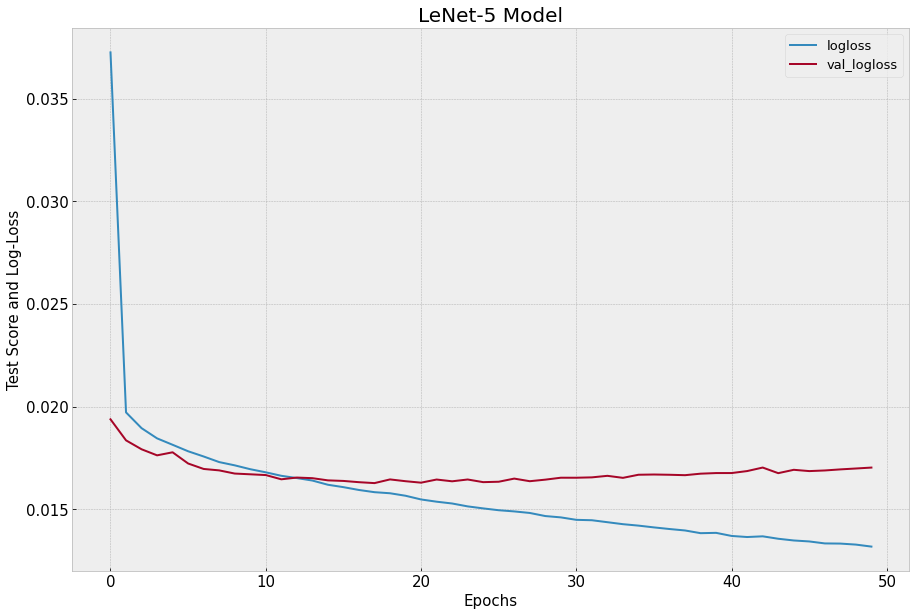

In [126]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_lenet5.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('LeNet-5 Model', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/lenet5.jpg')

WIthout dropout, it started overfitting after 15 epochs severely. With dropout, it started overfitting after 20 epochs, but not severely.

Go back to try out mlp to see if mlp is getting better after PCA.

In [146]:
n_cols = X_pca_train.shape[1]
mlp_pca = build_model(n_cols)
mlp_pca.summary()

earlystp_mlp_pca = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/mlp_pca'
checkpoint_mlp_pca = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_mlp_pca = mlp_pca.fit(
    X_pca_train, y_train, batch_size=32,
    validation_data=(X_pca_val, y_val),
    epochs=50,
    callbacks=[checkpoint_mlp_pca, earlystp_mlp_pca])

score = mlp_pca.evaluate(X_pca_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

mlp_pca.save('models/mlp_pca_complete')

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 64)                7872      
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_41 (Batc (None, 128)               512       
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 206)               26574     
Total params: 43,278
Trainable params: 43,022
Non-trainable params: 256
_______________________________________________

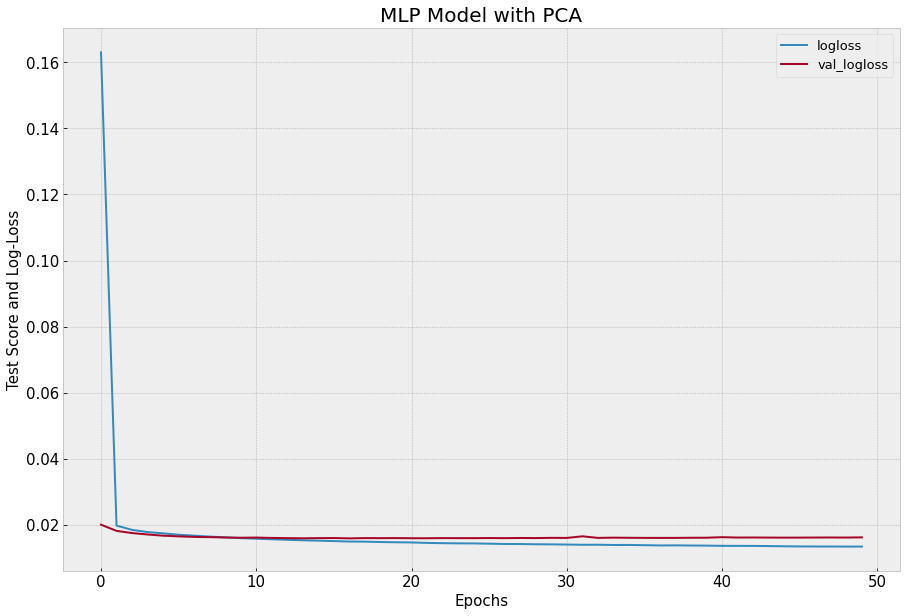

In [147]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_mlp_pca.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('MLP Model with PCA', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/mlp_pca.jpg')

It's obvious that PCA with 122 principal components did improved the MLP model a lot!!! If finally decide to go with MLP, then need to try out number of principal components 70.

Build a VGG16 net:
https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

In [150]:
def VGG16_model(n_cols):
    model = Sequential()
    model.add(Conv1D(input_shape=(n_cols, 1),filters=64,kernel_size=3,padding="same", activation="relu"))
    model.add(Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    model.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    model.add(MaxPooling1D(pool_size=2,strides=2))
    model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    model.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
    model.add(MaxPooling1D(pool_size=2,strides=2))

    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=206,activation="sigmoid"))
    
    # Compiling the model
    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)
    
    return model

#Model Summary
vgg16 = VGG16_model(n_cols)
vgg16.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_173 (Conv1D)          (None, 122, 64)           256       
_________________________________________________________________
conv1d_174 (Conv1D)          (None, 122, 64)           12352     
_________________________________________________________________
max_pooling1d_91 (MaxPooling (None, 61, 64)            0         
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 61, 128)           24704     
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 61, 128)           49280     
_________________________________________________________________
max_pooling1d_92 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
conv1d_177 (Conv1D)          (None, 30, 256)         

In [151]:
# Fit the VGG16 model
earlystp_vgg16 = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/vgg16'
checkpoint_vgg16 = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

history_vgg16 = vgg16.fit(
    X_pca_train_reshaped, y_train, batch_size=32,
    validation_data=(X_pca_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_vgg16, earlystp_vgg16])

score = vgg16.evaluate(X_pca_val_reshaped, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

vgg16.save('models/vgg16_complete')

Epoch 1/50
559/559 [==============================] - 14s 20ms/step - loss: 0.0523 - logloss: 0.0439 - val_loss: 0.0318 - val_logloss: 0.0221
INFO:tensorflow:Assets written to: models/vgg16/assets
Epoch 2/50
559/559 [==============================] - 10s 19ms/step - loss: 0.0243 - logloss: 0.0212 - val_loss: 0.0229 - val_logloss: 0.0198
INFO:tensorflow:Assets written to: models/vgg16/assets
Epoch 3/50
559/559 [==============================] - 10s 19ms/step - loss: 0.0230 - logloss: 0.0200 - val_loss: 0.0220 - val_logloss: 0.0187
INFO:tensorflow:Assets written to: models/vgg16/assets
Epoch 4/50
559/559 [==============================] - 11s 19ms/step - loss: 0.0225 - logloss: 0.0195 - val_loss: 0.0217 - val_logloss: 0.0185
INFO:tensorflow:Assets written to: models/vgg16/assets
Epoch 5/50
559/559 [==============================] - 11s 19ms/step - loss: 0.0218 - logloss: 0.0187 - val_loss: 0.0215 - val_logloss: 0.0184
INFO:tensorflow:Assets written to: models/vgg16/assets
Epoch 6/50
559/

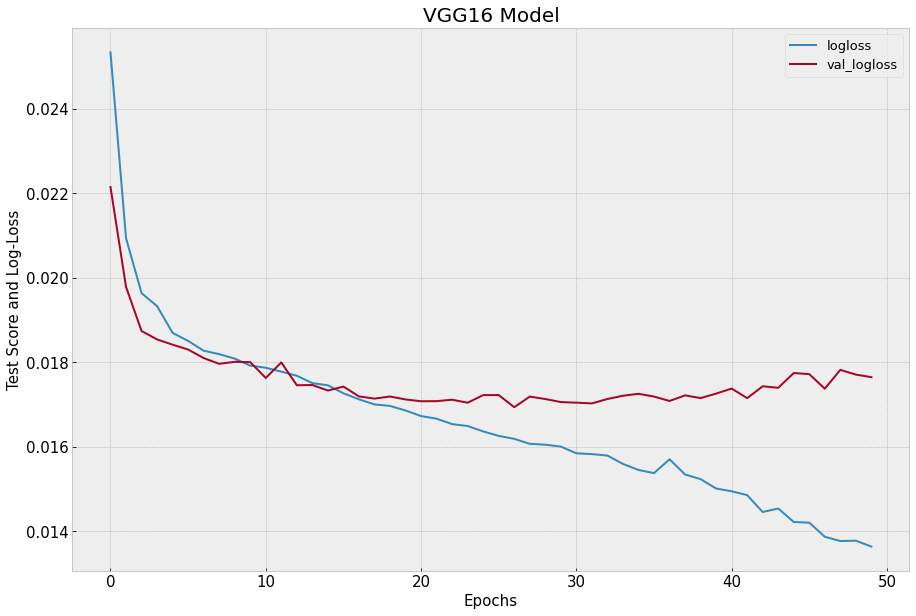

In [152]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_vgg16.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('VGG16 Model', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/vgg16.jpg')

Try ResNet:  https://adventuresinmachinelearning.com/introduction-resnet-tensorflow-2/

In [160]:
def ResNet_model(n_cols):
    def res_net_block(input_data, filters, conv_size):
        x = Conv1D(filters, conv_size, activation='relu', padding='same')(input_data)
        x = BatchNormalization()(x)
        x = Conv1D(filters, conv_size, activation=None, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, input_data])
        x = Activation('relu')(x)
        return x

    inputs = Input(shape=(n_cols, 1))
    x = Conv1D(32, 3, activation='relu')(inputs)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    num_res_net_blocks = 10
    for i in range(num_res_net_blocks):
        x = res_net_block(x, 64, 3)
    x = Conv1D(64, 3, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(206, activation='sigmoid')(x)
    res_net_model = Model(inputs, outputs)

    # Compiling the model
    res_net_model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)
    
    return res_net_model

#Model Summary
resnet = ResNet_model(n_cols)
resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 122, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_236 (Conv1D)             (None, 120, 32)      128         input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_237 (Conv1D)             (None, 118, 64)      6208        conv1d_236[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_99 (MaxPooling1D) (None, 39, 64)       0           conv1d_237[0][0]                 
____________________________________________________________________________________________

In [161]:
# Fit the ResNet model
earlystp_resnet = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/resnet'
checkpoint_resnet = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

history_resnet = resnet.fit(
    X_pca_train_reshaped, y_train, batch_size=32,
    validation_data=(X_pca_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_resnet, earlystp_resnet])

score = resnet.evaluate(X_pca_val_reshaped, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

resnet.save('models/resnet_complete')

Epoch 1/50
559/559 [==============================] - 18s 23ms/step - loss: 0.0796 - logloss: 0.0745 - val_loss: 0.0223 - val_logloss: 0.0191
INFO:tensorflow:Assets written to: models/resnet/assets
Epoch 2/50
559/559 [==============================] - 13s 22ms/step - loss: 0.0238 - logloss: 0.0205 - val_loss: 0.0217 - val_logloss: 0.0185
INFO:tensorflow:Assets written to: models/resnet/assets
Epoch 3/50
559/559 [==============================] - 13s 23ms/step - loss: 0.0229 - logloss: 0.0196 - val_loss: 0.0213 - val_logloss: 0.0182
INFO:tensorflow:Assets written to: models/resnet/assets
Epoch 4/50
559/559 [==============================] - 13s 23ms/step - loss: 0.0223 - logloss: 0.0191 - val_loss: 0.0211 - val_logloss: 0.0179
INFO:tensorflow:Assets written to: models/resnet/assets
Epoch 5/50
559/559 [==============================] - 12s 22ms/step - loss: 0.0218 - logloss: 0.0186 - val_loss: 0.0209 - val_logloss: 0.0178
INFO:tensorflow:Assets written to: models/resnet/assets
Epoch 6/50

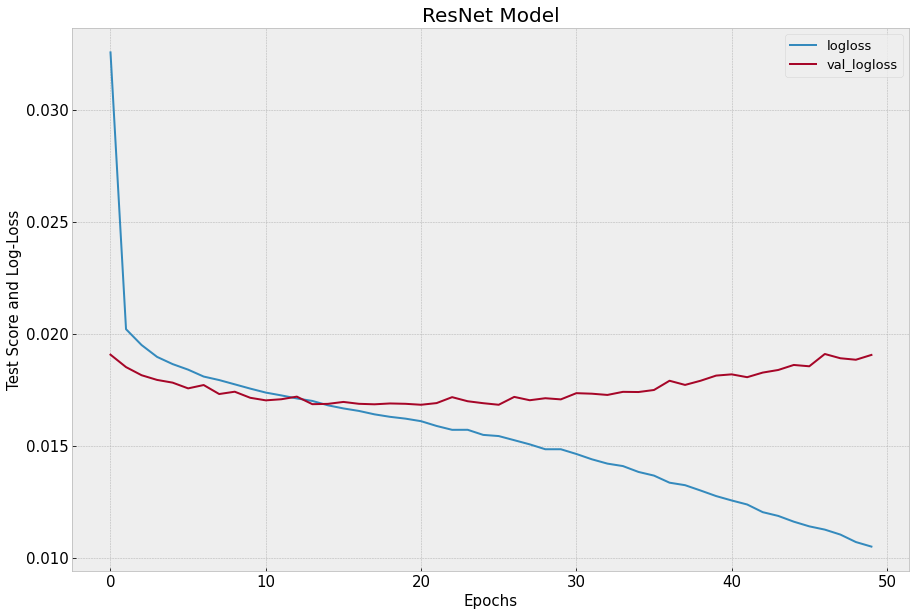

In [162]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_resnet.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('ResNet Model', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/resnet.jpg')

Tyr out Inception Net: https://maelfabien.github.io/deeplearning/inception/#in-keras

In [166]:
def inception_model(n_cols):

    input_data = Input(shape=(n_cols, 1))

    ### 1st layer
    layer_1 = Conv1D(10, 1, padding='same', activation='relu')(input_data)
    layer_1 = Conv1D(10, 3, padding='same', activation='relu')(layer_1)

    layer_2 = Conv1D(10, 1, padding='same', activation='relu')(input_data)
    layer_2 = Conv1D(10, 5, padding='same', activation='relu')(layer_2)

    layer_3 = MaxPooling1D(3, strides=1, padding='same')(input_data)
    layer_3 = Conv1D(10, 1, padding='same', activation='relu')(layer_3)

    mid_1 = concatenate([layer_1, layer_2, layer_3], axis = 2)

    flat_1 = Flatten()(mid_1)

    dense_1 = Dense(1200, activation='relu')(flat_1)
    dense_2 = Dense(600, activation='relu')(dense_1)
    dense_3 = Dense(150, activation='relu')(dense_2)
    output = Dense(206, activation='sigmoid')(dense_3)

    model = Model([input_data], output)

    # Compiling the model
    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)
    
    return model

#Model Summary
incep = inception_model(n_cols)
incep.summary()



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 122, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_269 (Conv1D)             (None, 122, 10)      20          input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_271 (Conv1D)             (None, 122, 10)      20          input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_102 (MaxPooling1D (None, 122, 1)       0           input_8[0][0]                    
____________________________________________________________________________________________

In [167]:
# Fit the ResNet model
earlystp_incep = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/inception'
checkpoint_incep = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

history_incep = incep.fit(
    X_pca_train_reshaped, y_train, batch_size=32,
    validation_data=(X_pca_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_incep, earlystp_incep])

score = incep.evaluate(X_pca_val_reshaped, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

incep.save('models/inception_complete')

Epoch 1/50
559/559 [==============================] - 4s 6ms/step - loss: 0.0597 - logloss: 0.0538 - val_loss: 0.0214 - val_logloss: 0.0182
INFO:tensorflow:Assets written to: models/inception/assets
Epoch 2/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0207 - logloss: 0.0175 - val_loss: 0.0203 - val_logloss: 0.0171
INFO:tensorflow:Assets written to: models/inception/assets
Epoch 3/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0196 - logloss: 0.0164 - val_loss: 0.0201 - val_logloss: 0.0167
INFO:tensorflow:Assets written to: models/inception/assets
Epoch 4/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0189 - logloss: 0.0157 - val_loss: 0.0201 - val_logloss: 0.0166
INFO:tensorflow:Assets written to: models/inception/assets
Epoch 5/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0179 - logloss: 0.0146 - val_loss: 0.0203 - val_logloss: 0.0167
INFO:tensorflow:Assets written to: models/inception/assets
Epoch

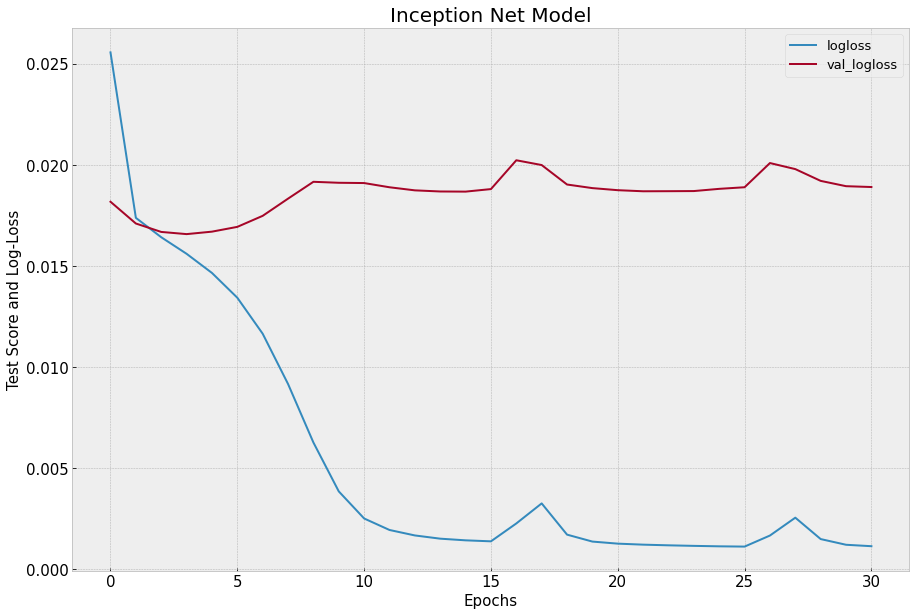

In [168]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_incep.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('Inception Net Model', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/incep.jpg')

Test to see if 1D-CNN model improves after PCA 

In [169]:
conv1d_pca = build_conv1D_model(n_cols)
conv1d_pca.summary()

# Fit the ResNet model
earlystp_conv1d_pca = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/conv1d_pca'
checkpoint_conv1d_pca = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

history_conv1d_pca = conv1d_pca.fit(
    X_pca_train_reshaped, y_train, batch_size=32,
    validation_data=(X_pca_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_conv1d_pca, earlystp_conv1d_pca])

score = conv1d_pca.evaluate(X_pca_val_reshaped, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

incep.save('models/conv1d_pca_complete')

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_274 (Conv1D)          (None, 120, 32)           128       
_________________________________________________________________
conv1d_275 (Conv1D)          (None, 118, 32)           3104      
_________________________________________________________________
conv1d_276 (Conv1D)          (None, 116, 64)           6208      
_________________________________________________________________
max_pooling1d_103 (MaxPoolin (None, 58, 64)            0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 58, 64)            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 3712)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 32)              

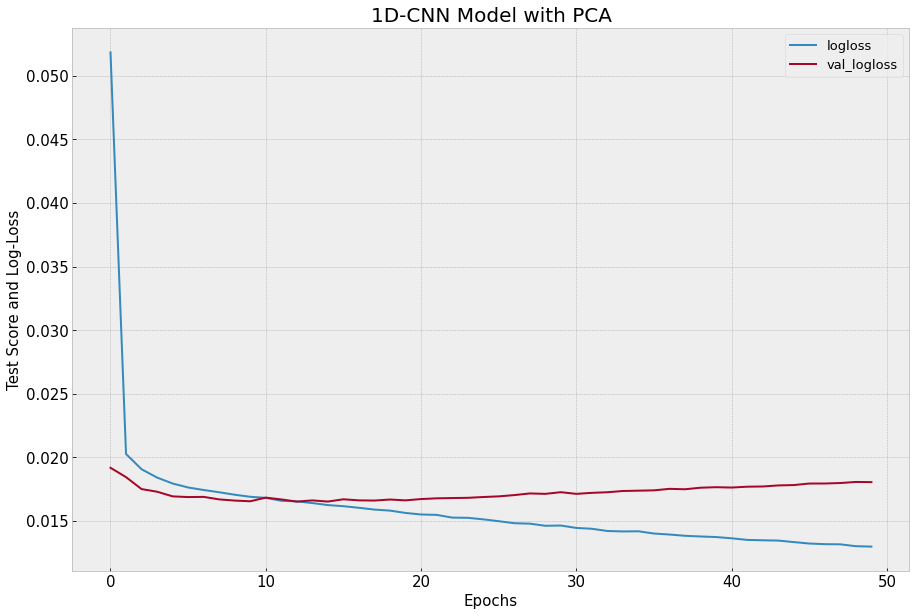

In [170]:
fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_conv1d_pca.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('1D-CNN Model with PCA', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/conv1d_pca.jpg')

Not as good as MLP+PCA, But better than 1D-CNN alone. Another evidence that PCA is doing a better job. 

MLP+PCA+Selu model:

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 64)                7872      
_________________________________________________________________
alpha_dropout_36 (AlphaDropo (None, 64)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 128)               8320      
_________________________________________________________________
alpha_dropout_37 (AlphaDropo (None, 128)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 206)               26574     
Total params: 42,766
Trainable params: 42,766
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
559/559 [==============================] - 3s 4ms/step - loss: 0.1839 - logloss: 0.1801 - val_loss: 0.03

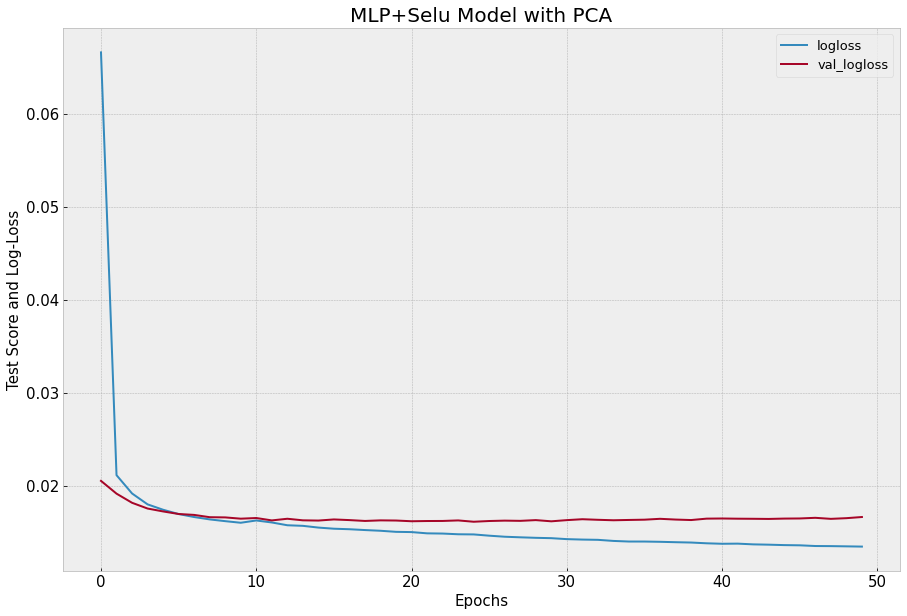

In [171]:
# Build a MLP+Selu model first
def mlp_selu_model(n_cols):
    model = Sequential()
    model.add(Dense(64, kernel_initializer=LecunNormal(), activation='selu', input_shape=(n_cols,)))
    model.add(AlphaDropout(0.1))
    model.add(Dense(128, kernel_initializer=LecunNormal(), activation='selu' ))
    model.add(AlphaDropout(0.1))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model 

n_cols = X_pca_train.shape[1]
mlp_pca_selu = mlp_selu_model(n_cols)
mlp_pca_selu.summary()

earlystp_mlp_pca_selu = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/mlp_pca_selu'
checkpoint_mlp_pca_selu = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_mlp_pca_selu = mlp_pca_selu.fit(
    X_pca_train, y_train, batch_size=32,
    validation_data=(X_pca_val, y_val),
    epochs=50,
    callbacks=[checkpoint_mlp_pca_selu, earlystp_mlp_pca_selu])

score = mlp_pca_selu.evaluate(X_pca_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

mlp_pca_selu.save('models/mlp_pca_selu_complete')

fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_mlp_pca_selu.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('MLP+Selu Model with PCA', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/mlp_pca_selu.jpg')

It is a little bit worse than MLP+PCA.

Now will try PCA number of 70.

In [6]:
# Get principal components
n_components = 70
pca70 = PCA(n_components=n_components)
X_pca70 = pca70.fit_transform(X)
X_pca70_train, X_pca70_val, y_train, y_val = train_test_split(X_pca70, y, test_size=0.25, shuffle=True, random_state=1)

X_pca70_train_reshaped = X_pca70_train.reshape(X_pca70_train.shape[0], X_pca70_train.shape[1], 1)
X_pca70_val_reshaped = X_pca70_val.reshape(X_pca70_val.shape[0], X_pca70_val.shape[1], 1)

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 64)                4544      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_104 (Bat (None, 128)               512       
_________________________________________________________________
dropout_29 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 206)               26574     
Total params: 39,950
Trainable params: 39,694
Non-trainable params: 256
_______________________________________________

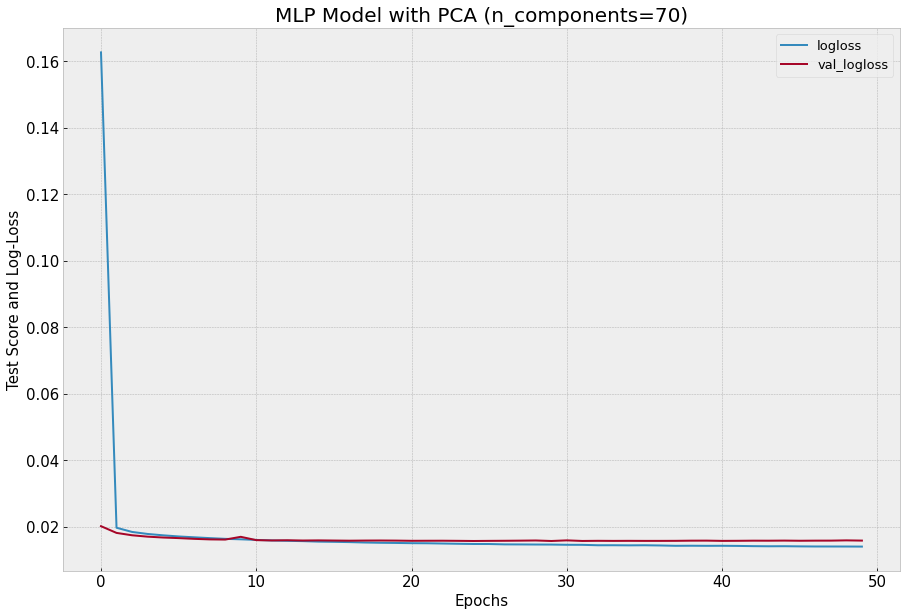

In [173]:
# Try the MLP model with 70 principal components

n_cols = X_pca70_train_reshaped.shape[1]
mlp_pca70 = build_model(n_cols)
mlp_pca70.summary()

earlystp_mlp_pca70 = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/mlp_pca70'
checkpoint_mlp_pca70 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_mlp_pca70 = mlp_pca70.fit(
    X_pca70_train, y_train, batch_size=32,
    validation_data=(X_pca70_val, y_val),
    epochs=50,
    callbacks=[checkpoint_mlp_pca70, earlystp_mlp_pca70])

score = mlp_pca70.evaluate(X_pca70_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])

mlp_pca70.save('models/mlp_pca70_complete')

fig, ax = plt.subplots(figsize=(15,10))
[ax.plot(history_mlp_pca70.history[i], label=i) for i in ['logloss', 'val_logloss']] #history_alexnet.history.keys()]
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Test Score and Log-Loss', fontsize=15)
ax.set_title('MLP Model with PCA (n_components=70)', fontsize=20)
plt.legend(fontsize=13, loc='best')
plt.savefig('images/mlp_pca70.jpg')

Best model so far: MLP+PCA(n_components=70). Not overfitting yet, can do more epochs.

Try out other classification models

In [5]:
def logloss_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return log_loss(y, y_pred) / y.shape[1]    

In [175]:
rf = RandomForestClassifier(n_estimators=100,
                            n_jobs=-2,
                            random_state=1,
                            verbose=1)

In [177]:
rf.fit(X_pca70_train, y_train)

RandomForestClassifier(n_jobs=-2, random_state=1)

In [187]:
y_pred_rf = rf.predict(X_pca70_val)

In [196]:
y_pred_rf.shape, y_val.shape

((5954, 206), (5954, 206))

In [193]:
log_loss(y_val, y_pred_rf)/206

0.01652875779303385

In [205]:
logloss_rf = logloss_scorer(rf, X_pca70_val, y_val)
logloss_rf

0.01652875779303385

In [200]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_pca70_train, y_train)
logloss_dt = logloss_scorer(dt, X_pca70_val, y_val)
logloss_dt

0.068453899068737

In [221]:
# the fit method of GDBR does not return a [n_samples, n_output] array. So multi-outputs or multi-label classification is not supported.
# but one can use a MultiOutputClassifier adapter, it takes algorithms like GradientBoosting and fit one instance per target. The problem
# of this approach is that you won't be able to take advantage of correlations between the outputs this way. In my case, I have 206 labels.
# So it will do 206 binary classifications, each with 100 estimators (in this case decision trees). It takes too long to run.
# https://scikit-learn.org/dev/modules/classes.html#module-sklearn.multioutput


# from sklearn.multioutput import MultiOutputClassifier

# gdbr = GradientBoostingClassifier(learning_rate=0.1,
#                                   n_estimators=100,
#                                   random_state=1,
#                                   verbose=1)

# clf = MultiOutputClassifier(gdbr).fit(X_pca70_train, y_train)

In [210]:
# The log of output is too long, because I set verbose=1, so I just comment out the above codes
# and rerun it to get rid of the long output. Actually the clf is fitted, and gave the following logloss
logloss_gdbr = logloss_scorer(clf, X_pca70_val, y_val)
logloss_gdbr

0.03959423183832766

This sklearn GradientBoostingClassifier with MultiOutputClassifier adaptor is taking too much time to run, and the result is bad. Will try to run XGBoost instead.

In [76]:
# XGBoost is an algorithm that has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data. 
# XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
# Using parameters from https://www.kaggle.com/fchmiel/xgboost-baseline-multilabel-classification
xgb = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist', verbosity=0))

params = {'estimator__colsample_bytree': 0.6522,
          'estimator__gamma': 3.6975,
          'estimator__learning_rate': 0.0503,
          'estimator__max_delta_step': 2.0706,
          'estimator__max_depth': 10,
          'estimator__min_child_weight': 31.5800,
          'estimator__n_estimators': 166,
          'estimator__subsample': 0.8639
         }

xgb.set_params(**params)
xgb.fit(X_pca70_train, y_train)

logloss_xgb = logloss_scorer(xgb, X_pca70_val, y_val)
logloss_xgb

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.01697914367410565

Not bad actually, worth to explore more.

In [222]:
# Try a logistic regression model. It won't work with multilabel classification, need to use MultiOutputClassifier

lg = MultiOutputClassifier(LogisticRegression(max_iter=10000, tol=0.1, C=0.5, verbose=0, random_state=1))
lg.fit(X_pca70_train, y_train) 

logloss_lg = logloss_scorer(lg, X_pca70_val, y_val)
logloss_lg

0.01801492636086704

In [228]:
# Try a KNN model
kn = KNeighborsClassifier(n_neighbors=10)
kn.fit(X_pca70_train, y_train)

logloss_kn = logloss_scorer(kn, X_pca70_val, y_val)
logloss_kn

0.016849704128591846

Not bad!!!

In [239]:
# Try a Naive Bayes GaussianNB model, cannot use MultinomialNB because here we have continous data, and some are negative. MNB does not accept negatives.
# Try without PCA
gnb = MultiOutputClassifier(GaussianNB())
gnb.fit(X_train, y_train)

logloss_gnb = logloss_scorer(gnb, X_val, y_val)
logloss_gnb

0.02988081639619024

In [242]:
# Try PCA data
gnb = MultiOutputClassifier(GaussianNB())
gnb.fit(X_pca70_train, y_train)

logloss_gnb = logloss_scorer(gnb, X_pca70_val, y_val)
logloss_gnb

0.04339721394362252

Bad model, and PCA data even worse.

In [245]:
# Try AdaBoostClassifier model
ada = MultiOutputClassifier(AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=1))
ada.fit(X_pca70_train, y_train)

logloss_ada = logloss_scorer(ada, X_pca70_val, y_val)
logloss_ada

0.0171911075495508

Not too bad.

In [37]:
# Try out C-Support Vector Classification model
svc = MultiOutputClassifier(SVC())
svc.fit(X_pca70_train, y_train)

logloss_svc = logloss_scorer(svc, X_pca70_val, y_val)
logloss_svc

0.01665181818936668

Until now, I have built all possible neural network models and all classifier models we have learned. Now will choose some to fine tune.

In [250]:
# Try LogisticRegression using ClassifierChain instead of MultiOutputClassifier

lgc = ClassifierChain(LogisticRegression(max_iter=10000, tol=0.1, C=0.5, verbose=0, random_state=1))
lgc.fit(X_pca70_train, y_train) 

logloss_lgc = logloss_scorer(lgc, X_pca70_val, y_val)
logloss_lgc

0.017666146540804555

Using ClassifierChain for LogisticRegression is better than using MultiOutputClassifier!!!

In [254]:
gnbc = ClassifierChain(GaussianNB())
gnbc.fit(X_pca70_train, y_train)

logloss_gnbc = logloss_scorer(gnbc, X_pca70_val, y_val)
logloss_gnbc

0.1174666386411514

Much worse than MultiOutputClassifier in GNB case.

In [255]:
adac = ClassifierChain(AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=1))
adac.fit(X_pca70_train, y_train)

logloss_adac = logloss_scorer(adac, X_pca70_val, y_val)
logloss_adac

0.017154988963846925

A liitle bit better than MultiOutputClassifier!

In [256]:
# Try out C-Support Vector Classification model
svcc = ClassifierChain(SVC(kernel='rbf', gamma='auto'))
svcc.fit(X_pca70_train, y_train)

logloss_svcc = logloss_scorer(svcc, X_pca70_val, y_val)
logloss_svcc

0.017972462420923152

It's better than MultiOutputClassifier!

Now will choose MLP+PCA70 (0.0159), RandomForest+PCA70 (0.165), KNN+PCA70 (0.168), XGBoost+PCA70 (0.0170), SVC, LeNet5+PCA122 (0.0170) to do hyperparameter optimization.

In [19]:
# randomized search for KNN optimal hyperparameters

start = time.time()

# Important: I am using logloss as scorer, so the smaller the better. For RandomizedSearchCV, default is the greater the better!!!
# Also, have to use custom_loss(y_true, y_pred), not (estimator, X, y). Otherwsie, will raise error, because scorer will take 
# (estimator, X, y) as parameters, if custom_loss() also takes the same parameters, will cause problem.
def custom_loss(y_true, y_pred):
    return log_loss(y_true, y_pred) / y_true.shape[1]
scorer = make_scorer(custom_loss, greater_is_better=False)

# define search space
space={'n_neighbors':[5,6,7,8,9],
          'leaf_size':[3,4,5,6,7],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}

# define search
# total parameter space is 5x5x2x4=200, so use n_iter=100, half of 200.
kn_rsc = RandomizedSearchCV(KNeighborsClassifier(), space, n_iter=100, scoring=scorer, cv=3, n_jobs=-1, random_state=1)

# execute search
kn_rsc.fit(X_pca70_train, y_train)

# summarize result
means = kn_rsc.cv_results_['mean_test_score']
stds = kn_rsc.cv_results_['std_test_score']
params = kn_rsc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (kn_rsc.best_score_, kn_rsc.best_params_))

#best_kn_model = kn_search.best_estimator_


end = time.time()
print("total time:", round((end-start)/60, 1), 'minutes')

-0.017038 (0.000149) with: {'weights': 'uniform', 'n_neighbors': 9, 'leaf_size': 3, 'algorithm': 'ball_tree'}
-0.017158 (0.000141) with: {'weights': 'uniform', 'n_neighbors': 5, 'leaf_size': 7, 'algorithm': 'auto'}
-0.017047 (0.000146) with: {'weights': 'uniform', 'n_neighbors': 7, 'leaf_size': 6, 'algorithm': 'auto'}
-0.016841 (0.000088) with: {'weights': 'uniform', 'n_neighbors': 6, 'leaf_size': 3, 'algorithm': 'kd_tree'}
-0.017047 (0.000146) with: {'weights': 'uniform', 'n_neighbors': 7, 'leaf_size': 6, 'algorithm': 'brute'}
-0.017038 (0.000149) with: {'weights': 'uniform', 'n_neighbors': 9, 'leaf_size': 7, 'algorithm': 'brute'}
-0.017026 (0.000152) with: {'weights': 'distance', 'n_neighbors': 7, 'leaf_size': 7, 'algorithm': 'ball_tree'}
-0.017047 (0.000146) with: {'weights': 'uniform', 'n_neighbors': 7, 'leaf_size': 3, 'algorithm': 'auto'}
-0.017003 (0.000166) with: {'weights': 'distance', 'n_neighbors': 9, 'leaf_size': 5, 'algorithm': 'auto'}
-0.017038 (0.000149) with: {'weights':

Searched so many parameters, got more or less the same score as default KNN model. KNN default parameters are doing a good job already. 

In [38]:
# Hyperparameter tuning of KNN model with hyperopt library. 
# see https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model

start = time.time()

def score(params):
    print("Training with params: ")
    print(params)

    knn_model = KNeighborsClassifier(**params)
    knn_model.fit(X_pca70_train, y_train)
    
    predictions = knn_model.predict(X_pca70_val)
    score = log_loss(y_val, predictions)/y_val.shape[1]
    
    return {'loss': score, 'status': STATUS_OK}
 
space = {'n_neighbors': hp.choice('n_neighbors', list(range(1,30))),
        'leaf_size': hp.choice('leaf_size', list(range(1,50))), 
        'p': hp.choice('p', [1,2]), 
        'weights': hp.choice('weights', ['uniform', 'distance']), 
        'algorithm': hp.choice('algorithm', ['auto', 'ball_tree','kd_tree','brute'])
        }

trials = Trials()
best = fmin(score, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

# calculate the running time
end = time.time()
print("Total running time:", (end - start)/60, 'minutes')

Training with params:                                 
{'algorithm': 'brute', 'leaf_size': 4, 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
Training with params:                                                             
{'algorithm': 'auto', 'leaf_size': 36, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
Training with params:                                                             
{'algorithm': 'ball_tree', 'leaf_size': 6, 'n_neighbors': 28, 'p': 1, 'weights': 'distance'}
Training with params:                                                             
{'algorithm': 'ball_tree', 'leaf_size': 7, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
Training with params:                                                             
{'algorithm': 'brute', 'leaf_size': 48, 'n_neighbors': 22, 'p': 2, 'weights': 'uniform'}
Training with params:                                                             
{'algorithm': 'ball_tree', 'leaf_size': 35, 'n_neighbors': 27, 'p': 1, 'weight

In [42]:
# Grid search for RandomForest optimal hyperparameters
# takes so long time and is not working any how!!!

start = time.time()


rf_grid = RandomForestClassifier()

# define evaluation
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)  # cannot use this cv splitter for multilabel classification directly

# define search space
# space = {'bootstrap': [True, False],
#          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#          'max_features': ['auto', 'sqrt'],
#          'min_samples_leaf': [1, 2, 4],
#          'min_samples_split': [2, 5, 10],
#          'n_estimators': [50, 100, 150, 200,300, 400, 600, 800, 1000]}

space = {#'criterion':['gini','entropy'],
         #'max_depth': [3, 5, 9, 15, 25, 40, 60],
         #'max_features': ['log2', 'sqrt'],
         #'n_estimators':[50, 75, 100, 150, 200, 300]}
         'n_estimators':[75,125]}
         #'min_samples_leaf':[1,2,3],
         #'min_samples_split':[3,6,9]}


# define search
rf_search = GridSearchCV(rf_grid, space, cv=3, scoring=logloss_scorer, n_jobs=-1)

# execute search
rf_result = rf_search.fit(X_pca70_train, y_train)

# summarize result
print('Best Score: %s' % rf_result.best_score_)
print('Best Hyperparameters: %s' % rf_result.best_params_)


end = time.time()
print("total time:", end - start)

Best Score: 0.016685828110142548
Best Hyperparameters: {'n_estimators': 75}
total time: 3122.8549268245697


Only searched 1 parameter two values, 3 folds, took 52 mins. Also the code is not right, because GridSearch looks for higher score by default, but I want lower score for my logloss.

In [43]:
# Grid search for RandomForest optimal hyperparameters
# takes so long time and is not working any how!!!
# This code has problem, because GridSearchCV look for high score by default, but we have logloss as score, lower is better.
# Anyway, it's too slow, won't try it again. Maybe hyperopt will run much faster!!!???

start = time.time()


rf_grid = RandomForestClassifier()

space = {#'criterion':['gini','entropy'],
         #'max_depth': [3, 5, 9, 15, 25, 40, 60],
         #'max_features': ['log2', 'sqrt'],
         #'n_estimators':[50, 75, 100, 150, 200, 300]}
         'n_estimators':[100]}
         #'min_samples_leaf':[1,2,3],
         #'min_samples_split':[3,6,9]}

# define search
rf_search = GridSearchCV(rf_grid, space, cv=3, scoring=logloss_scorer, n_jobs=-1)

# execute search
rf_result = rf_search.fit(X_pca70_train, y_train)

# summarize result
print('Best Score: %s' % rf_result.best_score_)
print('Best Hyperparameters: %s' % rf_result.best_params_)


end = time.time()
print("total time:", end - start)

Best Score: 0.016718012562446153
Best Hyperparameters: {'n_estimators': 100}
total time: 2832.559918165207


It took so much time to run!!! 48 mins!!! Didn't optimize any parameters, actually only tried 3-fold CV. So if try combinations of parameters, will take a lot of time. Also the code is not right, because GridSearch looks for higher score by default, but I want lower score for my logloss. Anyway, up to now, tried 50, 75, 100, 125, 200 manually, seems best n_estimator is 50-100.

In [18]:
# Hyperparameter tuning of RandomForest model with hyperopt library. 
# see https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model


start = time.time()

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
#     dtrain = xgboost.DMatrix(X_pca70_train, label=y_train)
#     dvalid = xgboost.DMatrix(X_pca70_val, label=y_val)
#     watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    rf_model = RandomForestClassifier(**params)
    rf_model.fit(X_pca70_train, y_train)
    
    predictions = rf_model.predict(X_pca70_val)
    score = log_loss(y_val, predictions)/y_val.shape[1]
    
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    # loss = 1 - score
    return {'loss': score, 'status': STATUS_OK}
            
    #'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),

space = {'criterion': hp.choice('criterion', ['gini','entropy']),
        'max_depth': hp.choice('max_depth', [3,5,7,9]), 
        'max_features': hp.choice('max_features', ['log2','sqrt']), 
        #'n_estimators': hp.choice('n_estimators', [50,100,150,200,300]), 
        'n_estimators': hp.uniform('n_estimators', 50,300), 
        'min_samples_leaf': hp.choice('min_samples_leaf', [1,2,3]), 
        'min_samples_split': hp.choice('min_samples_split', [3,6,9])
        }

trials = Trials()
best = fmin(score, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

# calculate the running time
end = time.time()
print("Total running time:", (end - start)/60, 'minutes')

Training with params:                                 
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 193.89904576741316}
	Score 0.016882946108875134                           


Training with params:                                                                
{'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 155.34718088138123}
	Score 0.01672175915368756                                                           


Training with params:                                                                
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 175.4829254016741}
	Score 0.016835302900084927                                                         


Training with params:                                                               
{'criterion': 'entropy

It took 4h 16min to complete, optimized so many parameters, not bad!!! though the score are not good. Now I understand, the number for each parameter is the index of the list for that parameter, need to look for the real value in the list!!! If the parameter is given as hp.uniform() then it's the real value. 

In [8]:
# Hyperparameter tuning for XGBoost model with hyperopt library, seems working. 
# see https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

start = time.time()

def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['estimator__n_estimators'])
    del params['estimator__n_estimators']
#     dtrain = xgboost.DMatrix(X_pca70_train, label=y_train)
#     dvalid = xgboost.DMatrix(X_pca70_val, label=y_val)
#     watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    xgb_model = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist', n_estimators=num_round, verbosity=0))
    xgb_model.set_params(**params)
    xgb_model.fit(X_pca70_train, y_train)
    
    predictions = xgb_model.predict(X_pca70_val)
    score = log_loss(y_val, predictions)/y_val.shape[1]
    
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    # loss = 1 - score
    return {'loss': score, 'status': STATUS_OK}

space = {'estimator__n_estimators': hp.uniform('estimator__n_estimators', 50,500),
        'estimator__gamma': hp.uniform('estimator__gamma', 0.01,10), #'estimator__gamma': hp.uniform('gamma', 0.01,10) also works. maybe the latter string name is not important
        'estimator__colsample_bytree': hp.uniform('estimator__colsample_bytree', 0.0001,0.9999),
        'estimator__subsample': hp.uniform('estimator__subsample', .0001,.9999),
        'estimator__min_child_weight': hp.uniform('estimator__min_child_weight', 0.1,50),
        'estimator__max_depth': hp.choice('estimator__max_depth', [6,8,10,12,14]), 
        #'estimator__max_delta_step': hp.uniform('max_delta_step', 1,20),   # forgot to add this one
        'estimator__learning_rate': hp.uniform('estimator__learning_rate', 0.0001,0.001)
        }

trials = Trials()
best = fmin(score, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

# calculate the running time
end = time.time()
print("Total running time:", (end - start)/60, 'minutes')

Training with params:                                 
{'estimator__colsample_bytree': 0.6214783195842843, 'estimator__gamma': 2.132716096106639, 'estimator__learning_rate': 0.00035921854481782276, 'estimator__max_depth': 12, 'estimator__min_child_weight': 35.62760651253851, 'estimator__n_estimators': 158.31132379158433, 'estimator__subsample': 0.316104672481921}
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.0179117844763633                             


Training with params:                                                           
{'estimator__colsample_bytree': 0.025326569575549275, 'estimator__gamma': 0.981483255308742, 'estimator__learning_rate': 0.0007162037922446188, 'estimator__max_depth': 12, 'estimator__min_child_weight': 43.655823445369805, 'estimator__n_estimators': 182.0771760515177, 'estimator__subsample': 0.8273244773072242}
  2%|▏         | 1/50 [00:27<22:38, 27.73s/trial, best loss: 0.0179117844763633]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                      


Training with params:                                                           
{'estimator__colsample_bytree': 0.22470984454921625, 'estimator__gamma': 1.8341138326366042, 'estimator__learning_rate': 0.0008617203889414172, 'estimator__max_depth': 10, 'estimator__min_child_weight': 9.380297270440632, 'estimator__n_estimators': 448.9631977192294, 'estimator__subsample': 0.5957088499662792}
  4%|▍         | 2/50 [00:57<22:54, 28.64s/trial, best loss: 0.0179117844763633]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017175200102038848                                                     


Training with params:                                                             
{'estimator__colsample_bytree': 0.17314999764460526, 'estimator__gamma': 2.9739702760529676, 'estimator__learning_rate': 0.0005691909675448428, 'estimator__max_depth': 10, 'estimator__min_child_weight': 46.61246152314152, 'estimator__n_estimators': 476.46911274671896, 'estimator__subsample': 0.6976719337443649}
  6%|▌         | 3/50 [02:02<35:38, 45.51s/trial, best loss: 0.017175200102038848]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.018093467145402647                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.5189064847082138, 'estimator__gamma': 8.796161075733702, 'estimator__learning_rate': 0.0007837882503689429, 'estimator__max_depth': 12, 'estimator__min_child_weight': 28.189399373852343, 'estimator__n_estimators': 199.42152597783874, 'estimator__subsample': 0.3506611197676433}
  8%|▊         | 4/50 [03:08<41:10, 53.71s/trial, best loss: 0.017175200102038848]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017711977081482845                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.31846880674867156, 'estimator__gamma': 6.83412717499347, 'estimator__learning_rate': 0.00011384178710211005, 'estimator__max_depth': 8, 'estimator__min_child_weight': 19.51475217808204, 'estimator__n_estimators': 482.97597295865904, 'estimator__subsample': 0.8702653658894466}
 10%|█         | 5/50 [03:40<34:21, 45.82s/trial, best loss: 0.017175200102038848]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017012576336044312                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.15191454824612702, 'estimator__gamma': 4.66868711179125, 'estimator__learning_rate': 0.0003498190182989575, 'estimator__max_depth': 12, 'estimator__min_child_weight': 29.072095420900805, 'estimator__n_estimators': 239.0504941015218, 'estimator__subsample': 0.667364081279892}
 12%|█▏        | 6/50 [04:49<39:14, 53.51s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01798214826537485                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.6930597786861558, 'estimator__gamma': 7.841721949100503, 'estimator__learning_rate': 0.0007838749846628731, 'estimator__max_depth': 14, 'estimator__min_child_weight': 36.47225346334369, 'estimator__n_estimators': 377.29251925438973, 'estimator__subsample': 0.7559600500582623}
 14%|█▍        | 7/50 [05:26<34:34, 48.25s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017517205916299503                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.7416123265234765, 'estimator__gamma': 4.2849641224509645, 'estimator__learning_rate': 0.0009741286489202022, 'estimator__max_depth': 6, 'estimator__min_child_weight': 40.392096086710964, 'estimator__n_estimators': 417.9025653881714, 'estimator__subsample': 0.17939914975359522}
 16%|█▌        | 8/50 [06:29<36:57, 52.79s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.5979096390234881, 'estimator__gamma': 4.224427169420298, 'estimator__learning_rate': 0.0008504225364298054, 'estimator__max_depth': 14, 'estimator__min_child_weight': 23.6593226373588, 'estimator__n_estimators': 64.17866334996143, 'estimator__subsample': 0.5722505096722093}
 18%|█▊        | 9/50 [07:29<37:42, 55.19s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017416868952983743                                                       


Training with params:                                                              
{'estimator__colsample_bytree': 0.22512586491157138, 'estimator__gamma': 2.6117636605274304, 'estimator__learning_rate': 0.0007421707472219225, 'estimator__max_depth': 14, 'estimator__min_child_weight': 11.077819701050073, 'estimator__n_estimators': 110.78417280320633, 'estimator__subsample': 0.4681128381210444}
 20%|██        | 10/50 [07:45<28:38, 42.96s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017404703968173924                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.2451156856855957, 'estimator__gamma': 1.8644323944005488, 'estimator__learning_rate': 0.0007807616126007801, 'estimator__max_depth': 6, 'estimator__min_child_weight': 20.088313024981364, 'estimator__n_estimators': 278.19586998238617, 'estimator__subsample': 0.7319948386084929}
 22%|██▏       | 11/50 [08:06<23:40, 36.43s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017353924511284542                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.28790677948378746, 'estimator__gamma': 8.00326790564447, 'estimator__learning_rate': 0.0008987093571878115, 'estimator__max_depth': 10, 'estimator__min_child_weight': 34.061321511441506, 'estimator__n_estimators': 89.68126745094216, 'estimator__subsample': 0.7798077705304844}
 24%|██▍       | 12/50 [08:48<24:07, 38.10s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01748386625811904                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.6847632262034524, 'estimator__gamma': 4.676504120462606, 'estimator__learning_rate': 0.0007590171240693642, 'estimator__max_depth': 14, 'estimator__min_child_weight': 49.76718212596296, 'estimator__n_estimators': 199.78612243408273, 'estimator__subsample': 0.2191425572954321}
 26%|██▌       | 13/50 [09:05<19:35, 31.76s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.7513949960354664, 'estimator__gamma': 1.629966287497183, 'estimator__learning_rate': 0.00025532781654495195, 'estimator__max_depth': 10, 'estimator__min_child_weight': 4.011557338825889, 'estimator__n_estimators': 105.53022938375392, 'estimator__subsample': 0.7662604877968128}
 28%|██▊       | 14/50 [09:40<19:36, 32.69s/trial, best loss: 0.017012576336044312]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017007867713564946                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.40828416351580704, 'estimator__gamma': 0.09151073645226833, 'estimator__learning_rate': 0.00030471940704705487, 'estimator__max_depth': 8, 'estimator__min_child_weight': 17.60566729509343, 'estimator__n_estimators': 382.3989712244721, 'estimator__subsample': 0.20292383051680085}
 30%|███       | 15/50 [10:02<17:10, 29.46s/trial, best loss: 0.017007867713564946]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01805503604879484                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.25375301253803767, 'estimator__gamma': 4.1038568474741, 'estimator__learning_rate': 0.0005209103825881182, 'estimator__max_depth': 8, 'estimator__min_child_weight': 30.98947112790407, 'estimator__n_estimators': 283.45487129923674, 'estimator__subsample': 0.39986739424613976}
 32%|███▏      | 16/50 [10:56<20:52, 36.84s/trial, best loss: 0.017007867713564946]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.018091153683566806                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.21034417383677012, 'estimator__gamma': 4.165720110329656, 'estimator__learning_rate': 0.00028113236904834854, 'estimator__max_depth': 12, 'estimator__min_child_weight': 35.13849657150032, 'estimator__n_estimators': 207.10062494672403, 'estimator__subsample': 0.7241228431510478}
 34%|███▍      | 17/50 [11:37<20:59, 38.17s/trial, best loss: 0.017007867713564946]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017767337814692356                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.9267266134331422, 'estimator__gamma': 5.298079562710929, 'estimator__learning_rate': 0.00022603829207393862, 'estimator__max_depth': 12, 'estimator__min_child_weight': 0.39702010623432504, 'estimator__n_estimators': 380.3423118692903, 'estimator__subsample': 0.12453190315238696}
 36%|███▌      | 18/50 [12:10<19:31, 36.61s/trial, best loss: 0.017007867713564946]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017189417932526038                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.516531582117261, 'estimator__gamma': 4.177852899521973, 'estimator__learning_rate': 0.0005210758534870725, 'estimator__max_depth': 12, 'estimator__min_child_weight': 6.5312989232766325, 'estimator__n_estimators': 435.6329895806877, 'estimator__subsample': 0.4915714692932498}
 38%|███▊      | 19/50 [13:09<22:20, 43.23s/trial, best loss: 0.017007867713564946]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016707998440463032                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.8753863649342619, 'estimator__gamma': 6.103230962314047, 'estimator__learning_rate': 0.00046489141294677914, 'estimator__max_depth': 10, 'estimator__min_child_weight': 0.13281538985815322, 'estimator__n_estimators': 319.4755093661388, 'estimator__subsample': 0.964342581554694}
 40%|████      | 20/50 [14:15<25:00, 50.01s/trial, best loss: 0.016707998440463032]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017153567746301532                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.8130878849389658, 'estimator__gamma': 0.8905770106419116, 'estimator__learning_rate': 0.00010766863748970938, 'estimator__max_depth': 10, 'estimator__min_child_weight': 5.224614516270853, 'estimator__n_estimators': 328.7240782501539, 'estimator__subsample': 0.9862130708137313}
 42%|████▏     | 21/50 [15:11<25:05, 51.90s/trial, best loss: 0.016707998440463032]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01742537294048094                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.4514742344321337, 'estimator__gamma': 3.0713757084306144, 'estimator__learning_rate': 0.0006328532244407974, 'estimator__max_depth': 10, 'estimator__min_child_weight': 11.720092867210656, 'estimator__n_estimators': 114.14779672195947, 'estimator__subsample': 0.025947845479472875}
 44%|████▍     | 22/50 [16:09<25:04, 53.74s/trial, best loss: 0.016707998440463032]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.5112689177735342, 'estimator__gamma': 0.2970780226473726, 'estimator__learning_rate': 0.00043064658160261863, 'estimator__max_depth': 6, 'estimator__min_child_weight': 4.910129997751475, 'estimator__n_estimators': 317.7201465501907, 'estimator__subsample': 0.5322355638802372}
 46%|████▌     | 23/50 [16:29<19:37, 43.61s/trial, best loss: 0.016707998440463032]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016743992794163956                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.38897512728426614, 'estimator__gamma': 0.14205024069198224, 'estimator__learning_rate': 0.00046070596817179756, 'estimator__max_depth': 6, 'estimator__min_child_weight': 14.996476612883523, 'estimator__n_estimators': 336.8012989674778, 'estimator__subsample': 0.4818652069559091}
 48%|████▊     | 24/50 [17:20<19:47, 45.68s/trial, best loss: 0.016707998440463032]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016986880611765183                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.5322420229691418, 'estimator__gamma': 6.154246473457433, 'estimator__learning_rate': 0.0006426336475090523, 'estimator__max_depth': 6, 'estimator__min_child_weight': 4.743106630855944, 'estimator__n_estimators': 419.7944284044993, 'estimator__subsample': 0.5766697825175491}
 50%|█████     | 25/50 [18:10<19:36, 47.06s/trial, best loss: 0.016707998440463032]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01666232555796022                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.5824153978444929, 'estimator__gamma': 6.451012990902985, 'estimator__learning_rate': 0.0006438102123001941, 'estimator__max_depth': 6, 'estimator__min_child_weight': 7.82062272578392, 'estimator__n_estimators': 424.82916431503236, 'estimator__subsample': 0.6356344006983718}
 52%|█████▏    | 26/50 [19:12<20:36, 51.52s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016888156545698103                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.08342692933479745, 'estimator__gamma': 5.473880315601054, 'estimator__learning_rate': 0.0005761051720767769, 'estimator__max_depth': 6, 'estimator__min_child_weight': 0.21716569339019287, 'estimator__n_estimators': 498.7482048620761, 'estimator__subsample': 0.4021161357724121}
 54%|█████▍    | 27/50 [20:14<20:58, 54.73s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.3679044115890866, 'estimator__gamma': 7.257206425838775, 'estimator__learning_rate': 0.0006493198755662612, 'estimator__max_depth': 12, 'estimator__min_child_weight': 13.69334850293827, 'estimator__n_estimators': 418.0634541738948, 'estimator__subsample': 0.28956131530019835}
 56%|█████▌    | 28/50 [21:23<21:34, 58.85s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01734937591024242                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.6429594637256022, 'estimator__gamma': 9.583276984957934, 'estimator__learning_rate': 0.0005110820680578781, 'estimator__max_depth': 6, 'estimator__min_child_weight': 23.802041227389985, 'estimator__n_estimators': 459.3109436072814, 'estimator__subsample': 0.42788991176684227}
 58%|█████▊    | 29/50 [22:22<20:41, 59.11s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017607899987350066                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.5378013821661646, 'estimator__gamma': 3.4261782716320583, 'estimator__learning_rate': 0.0006757540592850729, 'estimator__max_depth': 12, 'estimator__min_child_weight': 3.577548276105264, 'estimator__n_estimators': 441.47597190568035, 'estimator__subsample': 0.2964442657049703}
 60%|██████    | 30/50 [23:29<20:26, 61.33s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016756760710759707                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.449505972405726, 'estimator__gamma': 5.722682325035397, 'estimator__learning_rate': 0.00041467540979531735, 'estimator__max_depth': 12, 'estimator__min_child_weight': 8.95332629111093, 'estimator__n_estimators': 361.3869104135203, 'estimator__subsample': 0.8808948045586735}
 62%|██████▏   | 31/50 [24:35<19:51, 62.69s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016766414804245556                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.00791193211810981, 'estimator__gamma': 9.7197552417281, 'estimator__learning_rate': 0.0005864900381220123, 'estimator__max_depth': 8, 'estimator__min_child_weight': 16.23448616413385, 'estimator__n_estimators': 496.4488632612359, 'estimator__subsample': 0.5559935134186337}
 64%|██████▍   | 32/50 [25:31<18:14, 60.83s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.3352305790662594, 'estimator__gamma': 8.565796889512894, 'estimator__learning_rate': 0.0001971956818336837, 'estimator__max_depth': 6, 'estimator__min_child_weight': 7.4251618674799875, 'estimator__n_estimators': 399.83722185254044, 'estimator__subsample': 0.6058479114448263}
 66%|██████▌   | 33/50 [26:38<17:42, 62.53s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016698756745272242                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.10504489970340958, 'estimator__gamma': 8.94092351949562, 'estimator__learning_rate': 0.0001810452429503983, 'estimator__max_depth': 6, 'estimator__min_child_weight': 1.9963923709697786, 'estimator__n_estimators': 249.58350691418707, 'estimator__subsample': 0.6286883198985951}
 68%|██████▊   | 34/50 [27:35<16:16, 61.05s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.018030693665000787                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.34477626949791573, 'estimator__gamma': 8.318951981915909, 'estimator__learning_rate': 0.0003403103323587224, 'estimator__max_depth': 6, 'estimator__min_child_weight': 21.587549980135286, 'estimator__n_estimators': 398.8745832014284, 'estimator__subsample': 0.828764735011542}
 70%|███████   | 35/50 [28:13<13:31, 54.07s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016953811711568973                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.4497930063711725, 'estimator__gamma': 6.994758075736167, 'estimator__learning_rate': 0.00017099137368930238, 'estimator__max_depth': 6, 'estimator__min_child_weight': 11.899518272569658, 'estimator__n_estimators': 463.6174392561226, 'estimator__subsample': 0.8998914559304818}
 72%|███████▏  | 36/50 [29:11<12:51, 55.11s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01670758400929322                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.062098723946151735, 'estimator__gamma': 9.012624975777578, 'estimator__learning_rate': 0.0009543265264294004, 'estimator__max_depth': 6, 'estimator__min_child_weight': 26.960593889861222, 'estimator__n_estimators': 349.78830874747973, 'estimator__subsample': 0.6634865639338102}
 74%|███████▍  | 37/50 [30:18<12:45, 58.86s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.1399753367919871, 'estimator__gamma': 7.385792610046357, 'estimator__learning_rate': 0.0003959851550326786, 'estimator__max_depth': 6, 'estimator__min_child_weight': 9.812112951098113, 'estimator__n_estimators': 301.9197888197247, 'estimator__subsample': 0.3394807961457522}
 76%|███████▌  | 38/50 [31:08<11:12, 56.02s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.018062080405201717                                                       


Training with params:                                                             
{'estimator__colsample_bytree': 0.29602020232279397, 'estimator__gamma': 6.448850441512049, 'estimator__learning_rate': 0.0008859607158840931, 'estimator__max_depth': 6, 'estimator__min_child_weight': 17.612029059032594, 'estimator__n_estimators': 475.2248561417772, 'estimator__subsample': 0.5874347596985938}
 78%|███████▊  | 39/50 [31:51<09:34, 52.20s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01708846599373474                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.5651125497327913, 'estimator__gamma': 8.529878265347824, 'estimator__learning_rate': 0.0006976106475310975, 'estimator__max_depth': 14, 'estimator__min_child_weight': 44.15081069621339, 'estimator__n_estimators': 240.11889611756422, 'estimator__subsample': 0.8101738362667569}
 80%|████████  | 40/50 [32:57<09:24, 56.46s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01757367435623593                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.640653089670987, 'estimator__gamma': 7.5761156327813, 'estimator__learning_rate': 0.0008112459270313974, 'estimator__max_depth': 8, 'estimator__min_child_weight': 2.6290137334365395, 'estimator__n_estimators': 408.0119876669268, 'estimator__subsample': 0.5224076314142093}
 82%|████████▏ | 41/50 [33:38<07:45, 51.72s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01669847061185489                                                        


Training with params:                                                             
{'estimator__colsample_bytree': 0.6452790691786089, 'estimator__gamma': 7.501943964219027, 'estimator__learning_rate': 0.0008223186219559334, 'estimator__max_depth': 8, 'estimator__min_child_weight': 2.436083044135182, 'estimator__n_estimators': 355.0597306334423, 'estimator__subsample': 0.5274796081716839}
 84%|████████▍ | 42/50 [34:41<07:21, 55.14s/trial, best loss: 0.01666232555796022]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016650838604285335                                                       


Training with params:                                                              
{'estimator__colsample_bytree': 0.9866353927839056, 'estimator__gamma': 4.886900214345047, 'estimator__learning_rate': 0.000929137092199634, 'estimator__max_depth': 8, 'estimator__min_child_weight': 39.638870527601746, 'estimator__n_estimators': 261.06955980862324, 'estimator__subsample': 0.43974488491493463}
 86%|████████▌ | 43/50 [35:37<06:27, 55.38s/trial, best loss: 0.016650838604285335]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01811347658587155                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.7634790608182717, 'estimator__gamma': 9.291907026174222, 'estimator__learning_rate': 0.0008391936752929186, 'estimator__max_depth': 8, 'estimator__min_child_weight': 21.375475315031018, 'estimator__n_estimators': 222.13314760552433, 'estimator__subsample': 0.05207935577190781}
 88%|████████▊ | 44/50 [36:18<05:05, 50.98s/trial, best loss: 0.016650838604285335]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.6990603312867152, 'estimator__gamma': 6.065733518603827, 'estimator__learning_rate': 0.0007286622384654004, 'estimator__max_depth': 8, 'estimator__min_child_weight': 31.52396988235692, 'estimator__n_estimators': 300.11994477943637, 'estimator__subsample': 0.6929230791677664}
 90%|█████████ | 45/50 [36:53<03:50, 46.15s/trial, best loss: 0.016650838604285335]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01748904602999079                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.8269240372468607, 'estimator__gamma': 3.7079134870716044, 'estimator__learning_rate': 0.0009907565132372617, 'estimator__max_depth': 8, 'estimator__min_child_weight': 13.87089402691855, 'estimator__n_estimators': 368.84414313153985, 'estimator__subsample': 0.37009353936927825}
 92%|█████████▏| 46/50 [37:39<03:05, 46.32s/trial, best loss: 0.016650838604285335]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.017213039767091733                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.9711203643686515, 'estimator__gamma': 7.936758518849806, 'estimator__learning_rate': 0.0008167855685078839, 'estimator__max_depth': 14, 'estimator__min_child_weight': 49.621461322180686, 'estimator__n_estimators': 352.6710510034906, 'estimator__subsample': 0.12199616105505667}
 94%|█████████▍| 47/50 [38:35<02:27, 49.18s/trial, best loss: 0.016650838604285335]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.01807923906462672                                                         


Training with params:                                                              
{'estimator__colsample_bytree': 0.6926775694363732, 'estimator__gamma': 9.999848945253216, 'estimator__learning_rate': 0.0006184543212595413, 'estimator__max_depth': 8, 'estimator__min_child_weight': 26.697215791885125, 'estimator__n_estimators': 159.07477682309099, 'estimator__subsample': 0.22684936238140224}
 96%|█████████▌| 48/50 [39:32<01:43, 51.55s/trial, best loss: 0.016650838604285335]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.018111781191780866                                                        


Training with params:                                                              
{'estimator__colsample_bytree': 0.6162198207456536, 'estimator__gamma': 6.56372914147187, 'estimator__learning_rate': 0.0007707267982261625, 'estimator__max_depth': 8, 'estimator__min_child_weight': 1.93715333310969, 'estimator__n_estimators': 176.28466640970026, 'estimator__subsample': 0.248448281564772}
 98%|█████████▊| 49/50 [39:59<00:44, 44.16s/trial, best loss: 0.016650838604285335]

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



	Score 0.016759823630362772                                                        


100%|██████████| 50/50 [40:29<00:00, 48.59s/trial, best loss: 0.016650838604285335]
best:  {'estimator__colsample_bytree': 0.6452790691786089, 'estimator__gamma': 7.501943964219027, 'estimator__learning_rate': 0.0008223186219559334, 'estimator__max_depth': 1, 'estimator__min_child_weight': 2.436083044135182, 'estimator__n_estimators': 355.0597306334423, 'estimator__subsample': 0.5274796081716839}
Total running time: 40.49571594397227 minutes


max_depth is actually 8, not 1, if check back the output log. Seems there is a bug for hyperopt? 

No, this is not a bug, 1 is the index number of max_depth parameter list, which corresponding to value 8. logloss improved from 0.0170 to 0.0167!!!

In [13]:
# Based on above hyperopt parameters, continue to do a RandomizedSearch for max_depth and learning_rate. 
# The below codes work for both RandomizedSearchCV and GridSearchCV.

start = time.time()

# Important: I am using logloss as scorer, so the smaller the better. Default of RandomizedSearchCV is the greater the better!!!
# Also, have to use custom_loss(y_true, y_pred), not (estimator, X, y). Otherwsie, will raise error, because scorer will take 
# (estimator, X, y) as parameters, if custom_loss() also takes the same parameters, will cause problem, and return NaN as score.
def custom_loss(y_true, y_pred):
    return log_loss(y_true, y_pred) / y_true.shape[1]  
scorer=make_scorer(custom_loss, greater_is_better=False)

# Alternative way: when define custom scorer, return negative score, then, the higher the better
# def custom_loss(estimator, X, y):
#     y_pred = estimator.predict(X)
#     return -log_loss(y, y_pred) / y.shape[1] 

xgb_rsc = RandomizedSearchCV(
            estimator=MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist', n_estimators=355, verbosity=0)),
            param_distributions={"estimator__learning_rate": [0.0004, 0.0008, 0.0014, 0.002],
                                "estimator__max_depth": [7,8,9,10],
                                "estimator__min_child_weight": [2.4361],
                                "estimator__gamma":[7.5019],
                                "estimator__colsample_bytree":[0.6453],                              
                                "estimator__subsample": [0.5275]
                                },
            cv=3, scoring=scorer, verbose=0, n_jobs=-1, n_iter=8, random_state=1) # 16 parameter sets, random take 8

xgb_rsc.fit(X_pca70_train, y_train)

# summarize results
means = xgb_rsc.cv_results_['mean_test_score']
stds = xgb_rsc.cv_results_['std_test_score']
params = xgb_rsc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (xgb_rsc.best_score_, xgb_rsc.best_params_))

end = time.time()
print("total time:", round((end-start)/60, 1), 'minutes')


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


-0.016903 (0.000060) with: {'estimator__subsample': 0.5275, 'estimator__min_child_weight': 2.4361, 'estimator__max_depth': 10, 'estimator__learning_rate': 0.0004, 'estimator__gamma': 7.5019, 'estimator__colsample_bytree': 0.6453}
-0.016844 (0.000141) with: {'estimator__subsample': 0.5275, 'estimator__min_child_weight': 2.4361, 'estimator__max_depth': 8, 'estimator__learning_rate': 0.002, 'estimator__gamma': 7.5019, 'estimator__colsample_bytree': 0.6453}
-0.016888 (0.000091) with: {'estimator__subsample': 0.5275, 'estimator__min_child_weight': 2.4361, 'estimator__max_depth': 10, 'estimator__learning_rate': 0.0008, 'estimator__gamma': 7.5019, 'estimator__colsample_bytree': 0.6453}
-0.016903 (0.000060) with: {'estimator__subsample': 0.5275, 'estimator__min_child_weight': 2.4361, 'estimator__max_depth': 9, 'estimator__learning_rate': 0.0004, 'estimator__gamma': 7.5019, 'estimator__colsample_bytree': 0.6453}
-0.016888 (0.000091) with: {'estimator__subsample': 0.5275, 'estimator__min_child_w

Randomized Search got worse result than hyperopt. Use hyperopt parameters to train XGBoost model again.

In [14]:
# run XGBoost again with optimized parameters
xgb_opt = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist', verbosity=0))

params = {'estimator__colsample_bytree': 0.6453,
          'estimator__gamma': 7.5019,
          'estimator__learning_rate': 0.0008,
          #'estimator__max_delta_step': 2.0706,
          'estimator__max_depth': 8,
          'estimator__min_child_weight': 2.4361,
          'estimator__n_estimators': 355,
          'estimator__subsample': 0.5275
         }

xgb_opt.set_params(**params)
xgb_opt.fit(X_pca70_train, y_train)

logloss_xgb_opt = logloss_scorer(xgb_opt, X_pca70_val, y_val)
logloss_xgb_opt

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.016646494721761395

hyperopt optimizing is good!!! XGBoost model is not better than MLP model though.

In [16]:
# randomized search for SVC optimal hyperparameters

start = time.time()

# define search
svc_gsc = GridSearchCV(MultiOutputClassifier(SVC()),
                             param_grid = {'estimator__C': [10, 20], #[1, 5, 10, 40, 100], 
                                            'estimator__gamma': [0.1]}, #[1, 0.1, 0.01]},
                             scoring='neg_log_loss', cv=3, n_jobs=-1, verbose=1)

# execute search
svc_result = svc_gsc.fit(X_pca70_train, y_train)

# summarize result
print('Best Score: %s' % svc_result.best_score_)
print('Best Hyperparameters: %s' % svc_result.best_params_)


end = time.time()
print("total time:", end - start)

Yesterday, I used RandomizedSearchCV() and parameter space I commented out above. It took about 24 hours and didn't finish. So I stopped it. Don't know what's going wrong. Maybe just need time to complete? Also it seemed the scoring=logloss_scorer is not compatible here, as it showed the test score [nan, nan....]. Actually it's wrong code. GridSearchCV looks for higher scorer, but here we want logloss to be small.

Today, I changed to GridSearchCV() and used very few parameters, i.e. only 2 possible combinations, see above. So it's totalling 6 fits (3 fold cv). I noticed it used 6 CPUs (I have 8 CPUs on this EC2 g4dn instance). It means each fit is using one CPU and 6 fits are running parallelly. I also noticed that the CPUs finished their job one by one, and less and less CPUs are running. And for the last CPU running, it seemed taking forever, never complete. So I stopped it again!!!

In [22]:
# Try to do a SVC hyperparameter optimization with hyperopt

start = time.time()

def score(params):
    print("Training with params: ")
    print(params)

    svc_model = MultiOutputClassifier(SVC(**params))
    svc_model.fit(X_pca70_train, y_train)
    
    predictions = svc_model.predict(X_pca70_val)
    score = log_loss(y_val, predictions)/y_val.shape[1]
    
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    # loss = 1 - score
    return {'loss': score, 'status': STATUS_OK}

space = {'C': hp.uniform('C', 1,100),
        'gamma': hp.uniform('gamma', 0.0001,1.0), 
        }

trials = Trials()
best = fmin(score, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

# calculate the running time
end = time.time()
print("Total running time:", (end - start)/60, 'minutes')

The task only uses one CPU. So one evalution took more than 2 hour and didn't finish. I simply stopped it.

So try to compare different parameters for the SVC model manually:

In [27]:
start = time.time()

svc = ClassifierChain(SVC(kernel='rbf', gamma='auto', C=1))
svc.fit(X_pca70_train, y_train)

logloss_svc = logloss_scorer(svc, X_pca70_val, y_val)
print(logloss_svc)

# calculate the running time
end = time.time()
print("Total running time:", (end - start)/60, 'minutes')

Total running time: 21.241723807652793 minutes


In [28]:
logloss_svc

0.018002857419157085

It takes 21 mins to run, much slower than on local linux laptop, why??? Try the default gamma='scale':

In [29]:
start = time.time()

svc = ClassifierChain(SVC(kernel='rbf', gamma='scale', C=1))
svc.fit(X_pca70_train, y_train)

logloss_svc = logloss_scorer(svc, X_pca70_val, y_val)
print(logloss_svc)

# calculate the running time
end = time.time()
print("Total running time:", round((end-start)/60, 1), 'minutes')

0.016648466048809735
Total running time: 6.5 minutes


seems gamma='auto' takes 3 times longer than 'scale', and the result is also bad. Then I tried gamma=0.5, it takes even longer. So only 'scale' is fast, other options takes very long time. For kernel, I also tried different options. 'sigmoid' is very fast, but result is bad. 'poly' is a bit faster and better than 'rbf'. 'linear' takes long time. 'precomputed' is not working for this case. So will do a new hyperopt search of C and kernel(rbf and poly only due to time pressure).

In [36]:
# Try to do a SVC hyperparameter optimization with hyperopt

start = time.time()

def score(params):
    print("Training with params: ")
    print(params)

    svc_model = MultiOutputClassifier(SVC(**params))
    svc_model.fit(X_pca70_train, y_train)
    
    predictions = svc_model.predict(X_pca70_val)
    score = log_loss(y_val, predictions)/y_val.shape[1]
    
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    # loss = 1 - score
    return {'loss': score, 'status': STATUS_OK}

space = {'C': hp.uniform('C', 1,100),
        'kernel': hp.choice('kernel', ['rbf', 'poly']), 
        }

trials = Trials()
best = fmin(score, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

# calculate the running time
end = time.time()
print("Total running time:", (end - start)/60, 'minutes')

Training with params:                                 
{'C': 60.214501042124795, 'kernel': 'rbf'}            
	Score 0.017336530524484417                           


Training with params:                                                                
{'C': 36.42794364324375, 'kernel': 'poly'}                                           
	Score 0.017771148155940275                                                          


Training with params:                                                                
{'C': 4.200318539595042, 'kernel': 'poly'}                                           
	Score 0.01691836108660967                                                           


Training with params:                                                                
{'C': 67.32189307623973, 'kernel': 'rbf'}                                           
	Score 0.01756947638131806                                                          


Training with params:                                  

It took 3 hours 36 mins to finish the training, and Log-loss improved from 0.0167 to 0.0164. rbf is default for KNN, scale is also default. So basically it only changed C from default 1.0 to 11.15.

In [26]:
# Hyperparameter tuning for LeNet-5 model with hyperopt library. 
# see https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model

import sys

space = {'kernel_size1': hp.choice('kernel_size1',[3,5,7]),
        'kernel_size2': hp.choice('kernel_size2',[3,5,7]),
        'strides1': hp.choice('strides1',[1,2,3]),
        'strides2': hp.choice('strides2',[1,2,3 ]),
        'dropout1': hp.uniform('dropout1', .1,.5),
        'dropout2': hp.uniform('dropout2',  .1,.5),
        'dropout3': hp.uniform('dropout3', .1,.5),
        'dropout4': hp.uniform('dropout4',  .1,.5),
        'batch_size': hp.choice('batch_size', [32,64,128]),  #has to be int32, cannot use hp.uniform
        'lr': hp.uniform('lr', 0.0001,0.001),
        #'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
        #'activation': 'relu'
        }

def f_nn(params):   

    print ('Params testing: ', params)
    model = Sequential()

    model.add(Conv1D(filters=96, input_shape=(X_pca70_train_reshaped.shape[1],1), kernel_size=params['kernel_size1'], strides=params['strides1'], activation='relu'))
    model.add(AveragePooling1D())
    model.add(Dropout(params['dropout1']))

    model.add(Conv1D(filters=96, input_shape=(X_pca70_train_reshaped.shape[1],1), kernel_size=params['kernel_size2'], strides=params['strides2'], activation='relu'))
    model.add(AveragePooling1D())
    model.add(Dropout(params['dropout2']))

    model.add(Flatten())

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(params['dropout3']))

    model.add(Dense(units=96, activation='relu'))
    model.add(Dropout(params['dropout4']))

    model.add(Dense(units=206, activation='sigmoid'))
    
    # Compiling the model
    model.compile(optimizer=Adam(lr=params['lr'], decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    model.fit(X_pca70_train_reshaped, y_train, epochs=30, batch_size=params['batch_size'], verbose=0)


    score_logloss = model.evaluate(X_pca70_val_reshaped, y_val, verbose=0)
    print('Log-Loss:', score_logloss[1])
    sys.stdout.flush() 
    return {'loss': score_logloss[1], 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)


Params testing:                                       
{'batch_size': 128, 'dropout1': 0.22901942327696556, 'dropout2': 0.37685553840342423, 'dropout3': 0.46471653634129506, 'dropout4': 0.24544958879086223, 'kernel_size1': 3, 'kernel_size2': 3, 'lr': 0.0001071725676103973, 'strides1': 3, 'strides2': 2}
Log-Loss:                                             
0.018963545560836792                                  
Params testing:                                                                   
{'batch_size': 64, 'dropout1': 0.26955649051228125, 'dropout2': 0.4447986414088383, 'dropout3': 0.24146451743957087, 'dropout4': 0.11174611981699654, 'kernel_size1': 7, 'kernel_size2': 5, 'lr': 0.0006089166776876662, 'strides1': 2, 'strides2': 1}
Log-Loss:                                                                         
0.01635044626891613                                                               
Params testing:                                                                   
{'batch

After hyperopt optimization, the LeNet-5 model improved from 0.0170 to 0.0161, a big improvement.

In [104]:
# This working code is using the skleran MLPClassifier to do a hyperparameter searching.
# The problem is by default, GridSearchCV take highest score as best. In my case, it should
# be the lowest loss is the best. So need to re-define custom logloss function as below:

start = time.time()

parameter_space = {
    'hidden_layer_sizes': [(128), (128,256)],
    #'activation': ['tanh', 'relu'],
    #'solver': ['SGD', 'adam'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': [0.1, 0.01, 0.001, 0.0005]
}

# Important: I am using logloss as scorer, so the smaller the better. Default of RandomizedSearchCV is the greater the better!!!
# Also, have to use custom_loss(y_true, y_pred), not (estimator, X, y). Otherwsie, will raise error, because scorer will take 
# (estimator, X, y) as parameters, if custom_loss() also takes the same parameters, will cause problem, and return NaN as score.
def custom_loss(y_true, y_pred):
    return log_loss(y_true, y_pred) / y_true.shape[1]  
scorer=make_scorer(custom_loss, greater_is_better=False)

# Alternative way: when define custom scorer, return negative score, then, the higher the better
# def custom_loss(estimator, X, y):
#     y_pred = estimator.predict(X)
#     return -log_loss(y, y_pred) / y.shape[1]  

# There are 64 combinations of parameter sets, I randomly choose half, .i.e n_iter=32.
mlpclf = RandomizedSearchCV(MLPClassifier(max_iter=250), parameter_space, n_iter=32, scoring=scorer, n_jobs=-1, cv=3, random_state=1)
mlpclf.fit(X_pca70_train, y_train)

# summarize results
means = mlpclf.cv_results_['mean_test_score']
stds = mlpclf.cv_results_['std_test_score']
params = mlpclf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (mlpclf.best_score_, mlpclf.best_params_))


end = time.time()
print("total time:", (end - start)/60, 'minutes')

-0.017908 (0.000478) with: {'learning_rate_init': 0.1, 'learning_rate': 'constant', 'hidden_layer_sizes': (128, 256), 'alpha': 0.01}
-0.021618 (0.000327) with: {'learning_rate_init': 0.0005, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 128, 'alpha': 0.1}
-0.017949 (0.000180) with: {'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 128, 'alpha': 1}
-0.040387 (0.000383) with: {'learning_rate_init': 0.0005, 'learning_rate': 'constant', 'hidden_layer_sizes': (128, 256), 'alpha': 0.01}
-0.017318 (0.000777) with: {'learning_rate_init': 0.1, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (128, 256), 'alpha': 0.1}
-0.036638 (0.000992) with: {'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': 128, 'alpha': 0.001}
-0.041741 (0.001965) with: {'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 128, 'alpha': 0.01}
-0.017972 (0.000411) with: {'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidde

Now everything looks reasonable, except that the Randomized Search didn't give a really good result.

In [89]:
# Hyperparameter tuning with hyperopt library, seems working and fast. 
# see https://stackoverflow.com/questions/43533610/how-to-use-hyperopt-for-hyperparameter-optimization-of-keras-deep-learning-netwo


from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys

space = {'choice': hp.choice('num_layers',
                    [ {'layers':'two', },
                    {'layers':'three',
                    'units3': hp.uniform('units3', 64,256), 
                    'dropout3': hp.uniform('dropout3', .1,.4)}
                    ]),

            'units1': hp.uniform('units1', 64,256),
            'units2': hp.uniform('units2', 64,256),

            'dropout1': hp.uniform('dropout1', .1,.4),
            'dropout2': hp.uniform('dropout2',  .1,.4),

            #'batch_size' : hp.uniform('batch_size', 28,128),

            #'nb_epochs' :  30,
            #'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

def f_nn(params):   

    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(params['units1'], input_dim = X_pca70_train.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(params['units2'])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(params['choice']['units3'])) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(206))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=logloss)

    model.fit(X_pca70_train, y_train, epochs=20, batch_size=32, verbose = 0)

#     pred_auc =model.predict_proba(X_pca70_val, batch_size = 32, verbose = 0)
#     acc = roc_auc_score(y_val, pred_auc)
#     print('AUC:', acc)
#     sys.stdout.flush() 
#     return {'loss': -acc, 'status': STATUS_OK}

    # This code has problem, becuase logloss_ is a tf.Tensor() object, can't print out its value like this.
    pred = model.predict(X_pca70_val, batch_size = 32, verbose = 0)
    logloss_ = logloss(y_val, pred)
    print('Log-Loss:', logloss_)
    sys.stdout.flush() 
    return {'loss': logloss_, 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

                                                Params testing: 


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

                                                {'activation': 'relu', 'choice': {'layers': 'two'}, 'dropout1': 0.1789909667660825, 'dropout2': 0.3911591421790893, 'units1': 225.06251021413044, 'units2': 232.21648312846153}


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

                                                Log-Loss:


  0%|          | 0/50 [00:14<?, ?trial/s, best loss=?]

                                                tf.Tensor(0.016078077, shape=(), dtype=float32)


  0%|          | 0/50 [00:14<?, ?trial/s, best loss=?]

  2%|▏         | 1/50 [00:15<12:15, 15.00s/trial, best loss: 0.016078077256679535]

                                                                            Params testing: 


  2%|▏         | 1/50 [00:15<12:15, 15.00s/trial, best loss: 0.016078077256679535]

    

After hyperopt, test again with the optimized hyperparameters:

In [90]:
def mlp_model(n_cols, unit1=64, unit2=128, drop1=0.1, drop2=0.1, learn_rate=0.001, decay=0.001/200):
    model = Sequential()
    model.add(Dense(131, activation='relu', input_shape=(n_cols,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.364))
    model.add(Dense(206, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.276))
    model.add(Dense(112, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.175))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.0005, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model 

n_cols = X_pca70_train.shape[1]
mlp_tst = mlp_model(n_cols)
mlp_tst.summary()

history_mlp_tst = mlp_tst.fit(
    X_pca70_train, y_train, batch_size=32,
    validation_data=(X_pca70_val, y_val),
    epochs=50)

score = mlp_tst.evaluate(X_pca70_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test log-loss: ', score[1])


Model: "sequential_694"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2110 (Dense)           (None, 131)               9301      
_________________________________________________________________
batch_normalization_1275 (Ba (None, 131)               524       
_________________________________________________________________
dropout_1420 (Dropout)       (None, 131)               0         
_________________________________________________________________
dense_2111 (Dense)           (None, 206)               27192     
_________________________________________________________________
batch_normalization_1276 (Ba (None, 206)               824       
_________________________________________________________________
dropout_1421 (Dropout)       (None, 206)               0         
_________________________________________________________________
dense_2112 (Dense)           (None, 112)            

Yes, this set of hyperparameters from hyperopt gave more or less the same result as manually tuning.

In [51]:
# The following codes work very well to do a hyperparameter tuning for a Keras MLP model
# using sklearn RandomizedSearchCV() or GridSearchCV(). The only problem is that I cannot
# use my custom logloss_scorer() as scoring=logloss_scorer, probably the multilabel 
# classification is not supported by this KerasClassifier, and the evaluation score will
# be set as NAN. Consequently, RandomizedSearchCV() won't be able to choose the best 
# parameters. However, using other built-in metrics like neg_log_loss didn't cause problem???
# See https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


start = time.time()


# Function to create model, required for KerasClassifier
def mlp_model(n_cols, unit1=64, unit2=128, drop1=0.1, drop2=0.1, learn_rate=0.001, decay=0.001/200):
    model = Sequential()
    model.add(Dense(unit1, activation='relu', input_shape=(n_cols,)))
    model.add(BatchNormalization())
    model.add(Dropout(drop1))
    model.add(Dense(unit2, activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(drop2))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=learn_rate, decay=decay), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model 

# create model
n_cols = X_pca70_train.shape[1]
mlp_kclf = KerasClassifier(build_fn=mlp_model, epochs=5, batch_size=32, verbose=1)

# define the grid search parameters
learn_rate = [0.01, 0.001, 0.0005, 0.0001]
drop1 = [0.1, 0.2, 0.3, 0.4]
drop2 = [0.1, 0.2, 0.3, 0.4]
unit1 = [64, 128]
unit2 = [128, 256]
param_distributions = dict(unit1=unit1, n_cols=[n_cols], drop1=drop1, unit2=unit2, drop2=drop2, learn_rate=learn_rate)

mlp_rsc = RandomizedSearchCV(estimator=mlp_kclf, param_distributions=param_distributions, cv=3, n_iter=10, scoring='neg_log_loss', random_state=1)
mlp_result = mlp_rsc.fit(X_pca70_train, y_train)
 
# summarize results
mlp_means = mlp_result.cv_results_['mean_test_score']
mlp_stds = mlp_result.cv_results_['std_test_score']
mlp_params = mlp_result.cv_results_['params']
for mean, stdev, param in zip(mlp_means, mlp_stds, mlp_params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (mlp_result.best_score_, mlp_result.best_params_))


end = time.time()
print("total time:", (end - start)/60, 'minutes')

Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.5254 - logloss: 0.5248
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0276 - logloss: 0.0249
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0237 - logloss: 0.0205
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0227 - logloss: 0.0195
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.5257 - logloss: 0.5250
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0272 - logloss: 0.0245
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0235 - logloss: 0.0203
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0229 - logloss: 0.0196
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.5252 - logloss: 0.5246
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0274 - logloss: 0.0247
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0237 - logloss: 0.0205
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0230 - logloss: 0.0196
Epoch 5/5
 83/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1521 - logloss: 0.1494
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0220 - logloss: 0.0186
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0207 - logloss: 0.0175
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0204 - logloss: 0.0172
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1561 - logloss: 0.1536
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0217 - logloss: 0.0183
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0208 - logloss: 0.0176
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0204 - logloss: 0.0172
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1551 - logloss: 0.1525
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0219 - logloss: 0.0186
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0209 - logloss: 0.0176
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0205 - logloss: 0.0173
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6886 - logloss: 0.6884
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0580 - logloss: 0.0561
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0277 - logloss: 0.0250
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0247 - logloss: 0.0218
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6899 - logloss: 0.6896
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0588 - logloss: 0.0569
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0286 - logloss: 0.0260
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0246 - logloss: 0.0216
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6858 - logloss: 0.6855
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0590 - logloss: 0.0572
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0276 - logloss: 0.0250
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0247 - logloss: 0.0216
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6573 - logloss: 0.6570
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0492 - logloss: 0.0473
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0266 - logloss: 0.0239
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0240 - logloss: 0.0210
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6579 - logloss: 0.6576
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0494 - logloss: 0.0474
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0266 - logloss: 0.0240
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0241 - logloss: 0.0212
Epoch 5/5
 83/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6562 - logloss: 0.6560
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0493 - logloss: 0.0474
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0263 - logloss: 0.0237
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0240 - logloss: 0.0211
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6487 - logloss: 0.6486
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0639 - logloss: 0.0623
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0283 - logloss: 0.0259
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0247 - logloss: 0.0220
Epoch 5/5
 86/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6456 - logloss: 0.6455
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0633 - logloss: 0.0617
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0282 - logloss: 0.0258
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0245 - logloss: 0.0218
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6506 - logloss: 0.6504
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0637 - logloss: 0.0620
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0285 - logloss: 0.0261
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0246 - logloss: 0.0218
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.5261 - logloss: 0.5255
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0275 - logloss: 0.0247
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0239 - logloss: 0.0207
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0231 - logloss: 0.0198
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.5264 - logloss: 0.5258
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0275 - logloss: 0.0248
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0238 - logloss: 0.0206
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0231 - logloss: 0.0197
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.5277 - logloss: 0.5271
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0268 - logloss: 0.0240
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0238 - logloss: 0.0205
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0226 - logloss: 0.0193
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1540 - logloss: 0.1513
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0225 - logloss: 0.0191
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0215 - logloss: 0.0182
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0208 - logloss: 0.0176
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1532 - logloss: 0.1505
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0222 - logloss: 0.0189
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0214 - logloss: 0.0183
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0208 - logloss: 0.0176
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1555 - logloss: 0.1529
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0223 - logloss: 0.0190
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0215 - logloss: 0.0183
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0209 - logloss: 0.0177
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6198 - logloss: 0.6196
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0410 - logloss: 0.0390
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0247 - logloss: 0.0221
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0225 - logloss: 0.0196
Epoch 5/5
 81/187 [===========>..................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6175 - logloss: 0.6173
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0412 - logloss: 0.0393
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0248 - logloss: 0.0221
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0226 - logloss: 0.0197
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6218 - logloss: 0.6216
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0407 - logloss: 0.0387
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0247 - logloss: 0.0221
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0226 - logloss: 0.0197
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1334 - logloss: 0.1301
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0218 - logloss: 0.0184
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0209 - logloss: 0.0177
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0202 - logloss: 0.0171
Epoch 5/5
 82/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1342 - logloss: 0.1310
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0217 - logloss: 0.0183
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0206 - logloss: 0.0175
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0201 - logloss: 0.0169
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.1362 - logloss: 0.1329
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0222 - logloss: 0.0188
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0210 - logloss: 0.0178
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0205 - logloss: 0.0173
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6882 - logloss: 0.6879
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0600 - logloss: 0.0581
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0280 - logloss: 0.0254
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0247 - logloss: 0.0217
Epoch 5/5
 84/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6868 - logloss: 0.6865
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0586 - logloss: 0.0568
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0282 - logloss: 0.0256
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0251 - logloss: 0.0221
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
373/373 [==============================] - 2s 3ms/step - loss: 0.6845 - logloss: 0.6842
Epoch 2/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0584 - logloss: 0.0566
Epoch 3/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0280 - logloss: 0.0254
Epoch 4/5
373/373 [==============================] - 1s 3ms/step - loss: 0.0247 - logloss: 0.0217
Epoch 5/5
 85/187 [============>.................] - ETA: 0s

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/gpu_cuda11.0/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


187/187 [==============================] - 0s 1ms/step
Epoch 1/5
559/559 [==============================] - 2s 3ms/step - loss: 0.1186 - logloss: 0.1157
Epoch 2/5
559/559 [==============================] - 2s 3ms/step - loss: 0.0214 - logloss: 0.0181
Epoch 3/5
559/559 [==============================] - 2s 3ms/step - loss: 0.0205 - logloss: 0.0174
Epoch 4/5
559/559 [==============================] - 2s 3ms/step - loss: 0.0201 - logloss: 0.0170
Epoch 5/5
559/559 [==============================] - 2s 3ms/step - loss: 0.0202 - logloss: 0.0170
-2.803142 (0.029290) with: {'unit2': 256, 'unit1': 128, 'n_cols': 70, 'learn_rate': 0.001, 'drop2': 0.4, 'drop1': 0.3}
-2.646449 (0.014937) with: {'unit2': 128, 'unit1': 128, 'n_cols': 70, 'learn_rate': 0.01, 'drop2': 0.3, 'drop1': 0.1}
-2.940204 (0.014766) with: {'unit2': 256, 'unit1': 64, 'n_cols': 70, 'learn_rate': 0.0005, 'drop2': 0.4, 'drop1': 0.3}
-2.912112 (0.028548) with: {'unit2': 256, 'unit1': 64, 'n_cols': 70, 'learn_rate': 0.0005, 'drop2':

Because I cannot use my custom scoring function here. Not sure this neg_log_loss is a suitable score. Anyway, I have manually tuned the hyperparameters in another notebook.